In [1]:
# Update pip and install dependencies
!pip install --upgrade pip
!pip install PyWavelets antropy ace_tools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 48.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [antropy]


In [2]:
# Cell 2: Imports & Drive Mount
from google.colab import drive
drive.mount('/content/drive')

import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal, stats
from scipy.integrate import trapezoid
import pywt
import antropy as ant
from tqdm.auto import tqdm
from IPython.display import clear_output


# === Adjust this to the SHL data root ===
DATA_ROOT = '/content/drive/MyDrive/Baza danych Challange Sussex 2025/train_4_locations'  # or 'test', 'validation'

# Define sensor locations and modalities
LOCATIONS = ['Bag', 'Hips', 'Torso', 'Hand']
MODALITIES = {
    'Acc': ['x','y','z'],
    'Gyr': ['x','y','z'],
    'Mag': ['x','y','z'],
    'Label': [''],
}

# Utility to find all .txt files
def gather_files(root):
    files = []
    for loc in LOCATIONS:
        loc_path = os.path.join(root, loc)
        for mod, axes in MODALITIES.items():
            for axis in axes:
                if mod == 'Label':
                    pattern = f"{mod}" + ".txt"
                else:
                    pattern = f"{mod}" + (f"_{axis}" if axis else "") + ".txt"
                files.extend(glob.glob(os.path.join(loc_path, pattern)))
    return files

all_txt_files = gather_files(DATA_ROOT)
print(f"Found {len(all_txt_files)} files across {LOCATIONS}")


Mounted at /content/drive


KeyboardInterrupt: 

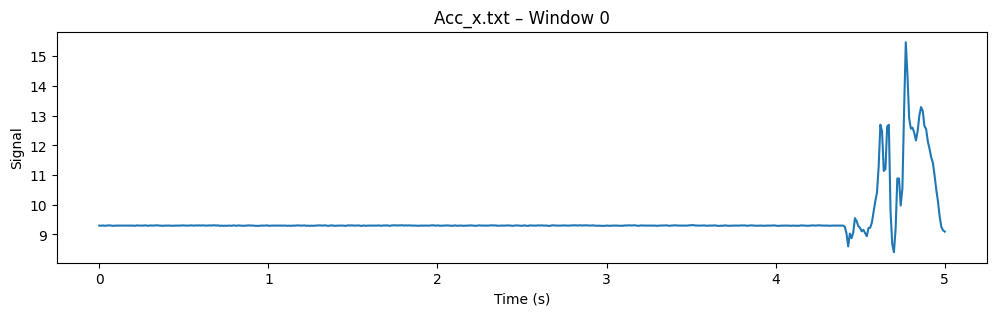

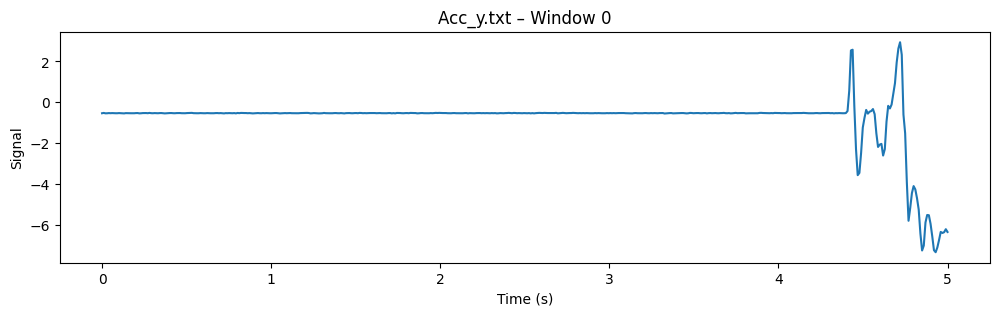

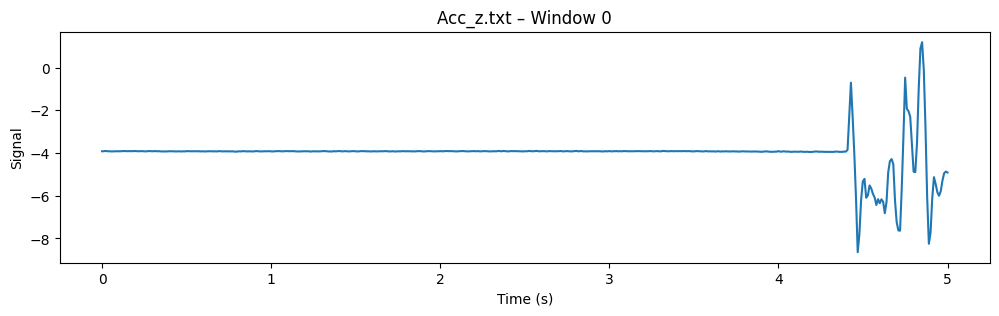

In [ ]:
def preview_window(file_path, window_idx=0):
    """Plot a single 5s window from a .txt file."""
    data = np.loadtxt(file_path)
    window = data[window_idx]    # shape (500,)
    plt.figure(figsize=(12,3))
    plt.plot(np.linspace(0,5,500), window)
    plt.title(os.path.basename(file_path) + f" – Window {window_idx}")
    plt.xlabel('Time (s)')
    plt.ylabel('Signal')
    plt.show()

# Preview first window of a few files
for f in all_txt_files[:3]:
    preview_window(f)


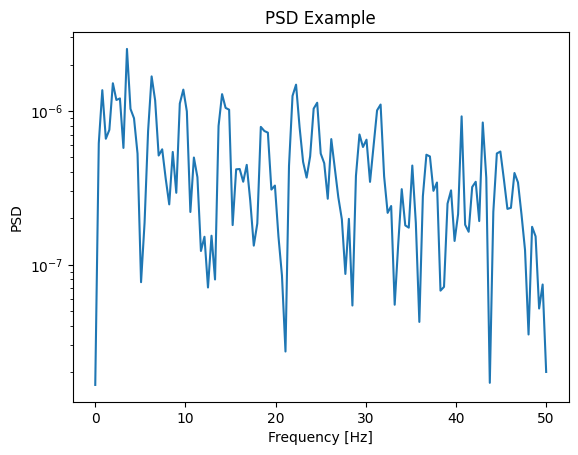

In [ ]:
# PSD of a single window
fs = 100  # from dataset spec
sig = np.loadtxt(all_txt_files[0])[0]
f, Pxx = signal.welch(sig, fs=fs, nperseg=256)
plt.semilogy(f, Pxx)
plt.title('PSD Example')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.show()


In [5]:
# ── Cell 3: Helpers for entropy & band energy ─────────────────────────────────

def differential_entropy(x):
    """
    Gaussian differential entropy of a 1D array x (in nats):
        h = 0.5 * ln(2πe·σ²)
    """
    var = np.var(x)
    return 0.5 * np.log(2 * np.pi * np.e * var)


def band_energy(psd, freqs, band):
    """
    Integrate PSD (or any power spectrum) over a given [low, high) Hz band
    using trapezoidal rule.
    """
    mask = (freqs >= band[0]) & (freqs < band[1])
    return trapezoid(psd[mask], freqs[mask])


In [6]:
# Cell 4: Funkcje ekstrakcji cech (70+ na okno)

def znormalize(x):
    return (x - x.mean()) / x.std()  # normalizacja do średniej 0 i odchylenia 1

def spectral_features(x, fs=100):
    xz = znormalize(x)
    freqs, Pxx = signal.welch(xz, fs=fs, nperseg=fs*2)  # PSD: gęstość widmowa mocy
    Xd = np.abs(np.fft.rfft(xz))                       # magnituda DCT (FFT)
    fd = np.fft.rfftfreq(len(xz), 1/fs)                 # odpowiadające częstotliwości

    bands = [(0.1,0.5),(0.5,1),(1,1.5),(1.5,2),(2,2.5),(2.5,3),
             (3,4),(4,5),(5,6),(6,8),(8,12),(12,18),
             (18,24),(24,28),(28,32),(32,40),(40,50)]
    feats = {}
    for prefix, f_arr, p_arr in [('psd', freqs, Pxx), ('dct', fd, Xd)]:
        for b in bands:
            feats[f'{prefix}_band_{b[0]}_{b[1]}'] = band_energy(p_arr, f_arr, b)
            # energia w paśmie b[0]-b[1] Hz

        cen = (f_arr * p_arr).sum() / p_arr.sum()
        feats[f'{prefix}_centroid']  = cen                                      # centroid widma: środek ciężkości energii częstotliwościowej

        bw = np.sqrt(((f_arr-cen)**2 * p_arr).sum() / p_arr.sum())
        feats[f'{prefix}_bandwidth'] = bw                                       # szerokość pasma: rozproszenie mocy wokół centroidu

        top2 = np.sort(p_arr)[-2:]
        feats[f'{prefix}_top2_ratio'] = top2[-1] / (top2[-2] + 1e-12)           # stosunek dwóch największych amplitud

        feats[f'{prefix}_amp_max']  = p_arr.max()                               # maksymalna amplituda widma

        feats[f'{prefix}_amp_std']  = p_arr.std()                               # odchylenie standardowe amplitud

        feats[f'{prefix}_amp_skew'] = stats.skew(p_arr)                         # skośność rozkładu amplitud

        pk = f_arr[np.argmax(p_arr)]
        feats[f'{prefix}_peak_freq'] = pk                                       # częstotliwość szczytowa

        top5_idx = np.argsort(p_arr)[-5:]
        top5 = f_arr[top5_idx]
        feats[f'{prefix}_top5_mean'] = top5.mean()                              # średnia 5 dominujących częstotliwości

        feats[f'{prefix}_top5_std']  = top5.std()                               # odchylenie standardowe 5 dominujących częstotliwości

        feats[f'{prefix}_top5_skew'] = stats.skew(top5)                         # skośność 5 dominujących częstotliwości

    p_norm = Pxx / Pxx.sum()
    feats['spectral_entropy'] = -(p_norm * np.log2(p_norm+1e-12)).sum()         # entropia widmowa: miara nieuporządkowania rozkładu mocy

    return feats

def time_acf_features(x):
    x0 = x - x.mean()
    acf = np.correlate(x0, x0, mode='full')[len(x0)-1:]
    feats = {
        'acf_mean_abs':       np.abs(acf).mean(),                     # średnia wartość bezwzględna ACF

        'acf_std':            acf.std(),                              # odchylenie standardowe ACF

        'acf_skew':           stats.skew(acf),                        # skośność ACF

        'acf_zero_crossings': ((acf[:-1]*acf[1:])<0).sum(),           # liczba zmian znaku w ACF
    }
    f_acf, P_acf = signal.welch(acf, fs=1)
    feats['acf_prom_freq'] = f_acf[P_acf.argmax()]
    # dominująca częstotliwość ACF

    p_acf = P_acf / P_acf.sum()
    feats['acf_spectral_entropy'] = -(p_acf * np.log2(p_acf+1e-12)).sum()
    # entropia widmowa ACF

    return feats

def time_signal_features(x):
    return {
        'mean_crossing_rate': ((x[:-1]*x[1:])<0).sum()/len(x),        # częstość przekroczeń średniej wartości (sign changes)

        'diff_entropy':       differential_entropy(x),                # entropia różnicowa Gaussa h=0.5·ln(2πeσ²)

        'skew':               stats.skew(x),                          # skośność rozkładu wartości

        'kurtosis':           stats.kurtosis(x),                      # kurtoza – miara smukłości rozkładu

        'hjorth_mobility':    ant.hjorth_params(x)[0],                # mobilność Hjortha – średnia częstotliwość

        'hjorth_complexity':  ant.hjorth_params(x)[1],                # złożoność Hjortha – zmiana mobilności

        'katz_fd':            ant.katz_fd(x),                         # wymiar fraktalny Katz’a – złożoność czasowa
    }

def extra_features(x, fs=100):
    feats = {'ptp_amp': np.ptp(x)}                                  # peak-to-peak: max–min amplitudy
    coeffs = pywt.wavedec(x, 'db4', level=3)
    for i, c in enumerate(coeffs):
        feats[f'wavelet_energy_L{i}'] = np.sum(c**2)                # energia na poziomie falki

    feats['sample_entropy'] = ant.sample_entropy(x)                 # sample entropy: miara nieregularności sygnału

    return feats


# Wyjaśnienia terminów

**Autokorelacja (ACF):** miara podobieństwa sygnału do swojej opóźnionej kopii, pomaga wykryć powtarzalność i okresowość w danych czasowych

**Centroid widma:** „środek ciężkości” rozkładu mocy widmowej, wskazuje, gdzie koncentruje się energia częstotliwościowa sygnału.

**Szerokość pasma:** odchylenie standardowe energii widma wokół centroidu, obrazujące rozproszenie częstotliwości.

**Entropia widmowa:** mierzy „nieuporządkowanie” lub równomierność rozkładu mocy widmowej; wyższa wartość = bardziej płaski, „niepikowy” wykres.

**Wskaźnik przekroczeń zerowych (ZCR):** liczba zmian znaku sygnału (pozytyw–negatyw) na sekundę, używana np. w detekcji perkusyjnych dźwięków.

**Entropia różnicowa:** ciągły odpowiednik entropii, dla rozkładu Gaussa.

**Mobilność i złożoność Hjortha:** parametry czasowe mierzące wariancję sygnału i jego pochodnych – mobilność ≈ średnia częstotliwość, złożoność ≈ zmiana tej częstotliwości.

**Wymiar fraktalny Katz’a:** miara złożoności sygnału obliczana z odległości między kolejnymi punktami próbek; im wyższy, tym większa „chropowatość”.

**Entropia próbki (sample entropy):** miara złożoności i nieregularności sygnału na podstawie prawdopodobieństwa powtórzeń wzorców.

In [ ]:
# Cell 5: Gather signal files & load labels with tqdm

DATA_ROOT = '/content/drive/MyDrive/Baza danych Challange Sussex 2025/train_4_locations'
LOCATIONS       = ['Bag','Hips','Torso','Hand']
SENSORS         = ['Acc','Gyr','Mag']
AXES            = ['x','y','z']
SAMPLES_PER_FILE = 1000    # ← number of windows to sample from each file

# 1) Gather all signal file paths
signal_files = []
for loc in LOCATIONS:
    for s in SENSORS:
        for ax in AXES:
            pattern = os.path.join(DATA_ROOT, loc, f"{s}_{ax}.txt")
            signal_files += glob.glob(pattern)
if not signal_files:
    raise FileNotFoundError(f"No .txt files under {DATA_ROOT}")

# 2) Extract fixed M samples per file
records = []
for fp in tqdm(signal_files, desc='Files', position=0, leave=False):
    data = np.loadtxt(fp)                # shape: (n_windows, 500)
    n_win = data.shape[0]
    # choose up to SAMPLES_PER_FILE unique indices
    picks = np.random.choice(n_win, size=min(SAMPLES_PER_FILE, n_win),
                             replace=False)
    loc    = os.path.basename(os.path.dirname(fp))
    sensor = os.path.splitext(os.path.basename(fp))[0]

    for i in tqdm(picks, desc=f'{sensor} windows',
                  position=1, leave=False):
        win = data[i]
        feats = {}
        feats.update(spectral_features(win))
        feats.update(time_acf_features(win))
        feats.update(time_signal_features(win))
        feats.update(extra_features(win))
        feats['location']    = loc
        feats['sensor_axis'] = sensor
        feats['window_id']   = i
        records.append(feats)

# 3) Build DataFrame
sample_df = pd.DataFrame(records)
print("Sampled feature set shape:", sample_df.shape)
sample_df.head()


Files:   0%|          | 0/36 [00:00<?, ?it/s]

Acc_x windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc_y windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc_z windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Gyr_x windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Gyr_y windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Gyr_z windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Mag_x windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Mag_y windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Mag_z windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc_x windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc_y windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc_z windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Gyr_x windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Gyr_y windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Gyr_z windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Mag_x windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Mag_y windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Mag_z windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc_x windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc_y windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc_z windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Gyr_x windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Gyr_y windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Gyr_z windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Mag_x windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Mag_y windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Mag_z windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc_x windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc_y windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc_z windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Gyr_x windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Gyr_y windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Gyr_z windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Mag_x windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Mag_y windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Mag_z windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampled feature set shape: (36000, 77)


psd_band_0.1_0.5  psd_band_0.5_1  psd_band_1_1.5  psd_band_1.5_2  \
0               0.0             0.0             0.0             0.0   
1               0.0             0.0             0.0             0.0   
2               0.0             0.0             0.0             0.0   
3               0.0             0.0             0.0             0.0   
4               0.0             0.0             0.0             0.0   

   psd_band_2_2.5  psd_band_2.5_3  psd_band_3_4  psd_band_4_5  psd_band_5_6  \
0             0.0             0.0      0.001710      0.002630      0.005986   
1             0.0             0.0      0.062259      0.004263      0.001302   
2             0.0             0.0      0.006298      0.011313      0.007502   
3             0.0             0.0      0.014906      0.006366      0.004420   
4             0.0             0.0      0.006495      0.017153      0.029920   

   psd_band_6_8  ...   katz_fd    ptp_amp  wavelet_energy_L0  \
0      0.002859  ...  3.979947   0.242166        2416.238630   
1      0.003249  ...  1.744960  20.578026       57041.464733   
2      0.011027  ...  4.056706   3.931250       46200.044051   
3      0.027510  ...  5.219011   0.057221         518.308206   
4      0.031318  ...  4.672659   0.042240       25416.319115   

   wavelet_energy_L1  wavelet_energy_L2  wavelet_energy_L3  sample_entropy  \
0           0.020356           0.284872           0.211413        1.411098   
1         109.282208          14.295576           2.251187        0.293064   
2          18.125772          74.225675          35.562182        1.793301   
3           0.008353           0.014965           0.028381        1.441748   
4           0.002686           0.009707           0.011010        1.577912   

   location  sensor_axis  window_id  
0       Bag        Acc_x       4904  
1       Bag        Acc_x      75167  
2       Bag        Acc_x     130033  
3       Bag        Acc_x      92078  
4       Bag        Acc_x      50775  

[5 rows x 77 columns]

Sampled feature set (first 20 rows):


psd_band_0.1_0.5  psd_band_0.5_1  psd_band_1_1.5  psd_band_1.5_2  \
0                0.0             0.0             0.0             0.0   
1                0.0             0.0             0.0             0.0   
2                0.0             0.0             0.0             0.0   
3                0.0             0.0             0.0             0.0   
4                0.0             0.0             0.0             0.0   
5                0.0             0.0             0.0             0.0   
6                0.0             0.0             0.0             0.0   
7                0.0             0.0             0.0             0.0   
8                0.0             0.0             0.0             0.0   
9                0.0             0.0             0.0             0.0   
10               0.0             0.0             0.0             0.0   
11               0.0             0.0             0.0             0.0   
12               0.0             0.0             0.0             0.0   
13               0.0             0.0             0.0             0.0   
14               0.0             0.0             0.0             0.0   
15               0.0             0.0             0.0             0.0   
16               0.0             0.0             0.0             0.0   
17               0.0             0.0             0.0             0.0   
18               0.0             0.0             0.0             0.0   
19               0.0             0.0             0.0             0.0   

    psd_band_2_2.5  psd_band_2.5_3  psd_band_3_4  psd_band_4_5  psd_band_5_6  \
0              0.0             0.0      0.001710      0.002630      0.005986   
1              0.0             0.0      0.062259      0.004263      0.001302   
2              0.0             0.0      0.006298      0.011313      0.007502   
3              0.0             0.0      0.014906      0.006366      0.004420   
4              0.0             0.0      0.006495      0.017153      0.029920   
5              0.0             0.0      0.013074      0.009886      0.012876   
6              0.0             0.0      0.004360      0.007405      0.004586   
7              0.0             0.0      0.005023      0.000896      0.000180   
8              0.0             0.0      0.011206      0.003128      0.001131   
9              0.0             0.0      0.013891      0.011006      0.022056   
10             0.0             0.0      0.012752      0.008286      0.007806   
11             0.0             0.0      0.023740      0.064034      0.003015   
12             0.0             0.0      0.012350      0.005142      0.003584   
13             0.0             0.0      0.011949      0.005352      0.008691   
14             0.0             0.0      0.053645      0.055247      0.016552   
15             0.0             0.0      0.010045      0.006266      0.041784   
16             0.0             0.0      0.006956      0.008811      0.038374   
17             0.0             0.0      0.054656      0.015460      0.079543   
18             0.0             0.0      0.005392      0.004330      0.004484   
19             0.0             0.0      0.029018      0.038438      0.055360   

    psd_band_6_8  ...   katz_fd    ptp_amp  wavelet_energy_L0  \
0       0.002859  ...  3.979947   0.242166        2416.238630   
1       0.003249  ...  1.744960  20.578026       57041.464733   
2       0.011027  ...  4.056706   3.931250       46200.044051   
3       0.027510  ...  5.219011   0.057221         518.308206   
4       0.031318  ...  4.672659   0.042240       25416.319115   
5       0.041326  ...  4.233336   0.042869        1409.604465   
6       0.012777  ...  2.618560   0.156967        1430.974708   
7       0.002445  ...  4.109686   1.459200       36618.133605   
8       0.007963  ...  2.852017   0.995119       37606.947270   
9       0.021853  ...  1.816348  13.366571       46643.099130   
10      0.025688  ...  2.492069   0.224070       44422.647348   
11      0.016560  ...  2.60159


Summary statistics:


psd_band_0.1_0.5  psd_band_0.5_1  psd_band_1_1.5  psd_band_1.5_2  \
count           36000.0         36000.0         36000.0         36000.0   
mean                0.0             0.0             0.0             0.0   
std                 0.0             0.0             0.0             0.0   
min                 0.0             0.0             0.0             0.0   
25%                 0.0             0.0             0.0             0.0   
50%                 0.0             0.0             0.0             0.0   
75%                 0.0             0.0             0.0             0.0   
max                 0.0             0.0             0.0             0.0   

       psd_band_2_2.5  psd_band_2.5_3  psd_band_3_4  psd_band_4_5  \
count         36000.0         36000.0  36000.000000  36000.000000   
mean              0.0             0.0      0.029120      0.021924   
std               0.0             0.0      0.035703      0.028818   
min               0.0             0.0      0.000006      0.000002   
25%               0.0             0.0      0.005430      0.003391   
50%               0.0             0.0      0.017046      0.011669   
75%               0.0             0.0      0.038835      0.029196   
max               0.0             0.0      0.471713      0.359223   

       psd_band_5_6  psd_band_6_8  ...  hjorth_mobility  hjorth_complexity  \
count  36000.000000  3.600000e+04  ...     36000.000000       36000.000000   
mean       0.017426  3.686586e-02  ...         0.375217           5.051167   
std        0.023950  4.798151e-02  ...         0.310193           6.678017   
min        0.000001  9.207850e-07  ...         0.006021           1.004403   
25%        0.002346  4.887744e-03  ...         0.148796           1.958220   
50%        0.008729  1.902001e-02  ...         0.296855           2.845105   
75%        0.023096  5.116037e-02  ...         0.490375           5.084395   
max        0.352491  6.358186e-01  ...         1.927713         145.660439   

            katz_fd       ptp_amp  wavelet_energy_L0  wavelet_energy_L1  \
count  36000.000000  36000.000000       3.600000e+04       3.600000e+04   
mean       2.321864      9.842418       2.140526e+06       8.794035e+02   
std        0.917845     27.497475       1.170933e+08       7.352397e+04   
min        1.012230      0.001222       1.143324e-05       7.862803e-06   
25%        1.767917      0.728424       4.847994e+01       6.111865e-01   
50%        2.140805      3.167750       9.195827e+03       1.925453e+01   
75%        2.598149     10.389743       7.669732e+04       4.113414e+01   
max       20.063975   2736.766554       8.359151e+09       1.224476e+07   

       wavelet_energy_L2  wavelet_energy_L3  sample_entropy      window_id  
count       3.600000e+04       36000.000000    36000.000000   36000.000000  
mean        2.178788e+02          44.775220        0.770146   98247.747556  
std         7.807516e+03        1092.208316        0.512929   56539.685270  
min         1.123123e-05           0.000007        0.000158      18.000000  
25%         2.592254e-01           0.038484        0.380175   49398.500000  
50%         6.025205e+00           1.513316        0.657761   98134.000000  
75%         1.079513e+01           3.729437        1.090006  147314.000000  
max         1.346816e+06      184036.849587        2.785893  196060.000000  

[8 rows x 75 columns]

<Figure size 800x800 with 0 Axes>

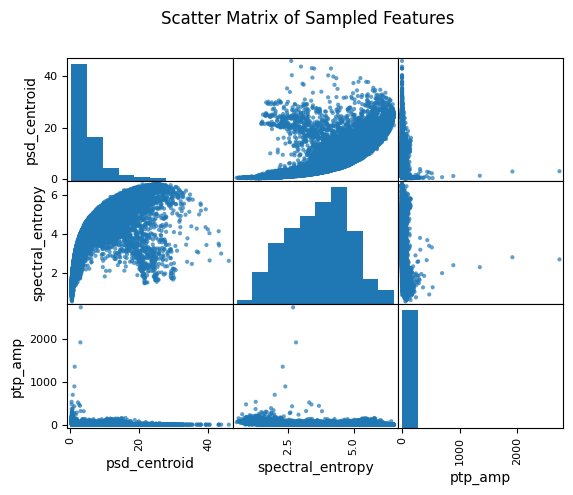

In [ ]:
# Cell 6: Visualize the sampled features without ace_tools

from IPython.display import display

# 1) Show the full DataFrame (or head)
print("Sampled feature set (first 20 rows):")
display(sample_df.head(20))

# 2) Simple summary stats
print("\nSummary statistics:")
display(sample_df.describe())

# 3) Scatter‐matrix plot
from pandas.plotting import scatter_matrix

fig = plt.figure(figsize=(8, 8))
scatter_matrix(
    sample_df[['psd_centroid', 'spectral_entropy', 'ptp_amp']],
    diagonal='hist',
    alpha=0.7
)
plt.suptitle('Scatter Matrix of Sampled Features')
plt.show()


In [ ]:
# Cell 7: Imports for advanced plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from IPython.display import display


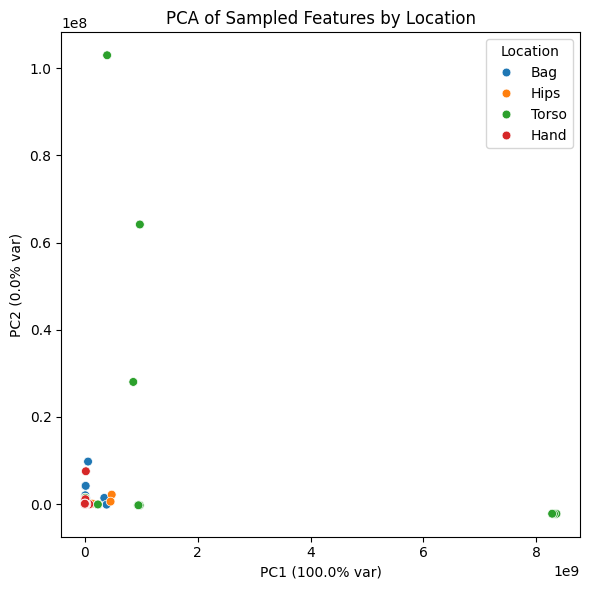

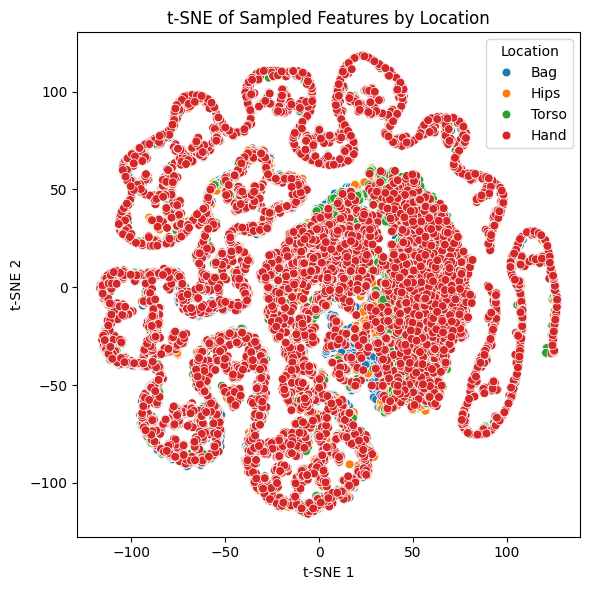

In [ ]:
# Cell 8: PCA + t-SNE colored by location

# Prepare feature matrix (drop metadata)
feat_cols = [c for c in sample_df.columns
             if c not in ('location','sensor_axis','window_id')]
X = sample_df[feat_cols].values

# 1) PCA to 2D
pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(6,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1],
                hue=sample_df['location'], palette='tab10', s=40)
plt.title('PCA of Sampled Features by Location')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)')
plt.legend(title='Location')
plt.tight_layout()
plt.show()

# 2) t-SNE to 2D
tsne = TSNE(n_components=2, random_state=0, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(6,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1],
                hue=sample_df['location'], palette='tab10', s=40)
plt.title('t-SNE of Sampled Features by Location')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Location')
plt.tight_layout()
plt.show()


<ipython-input-27-68dd41d6412f>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='location', y=feat, data=sample_df, inner='quartile', palette='Pastel1')


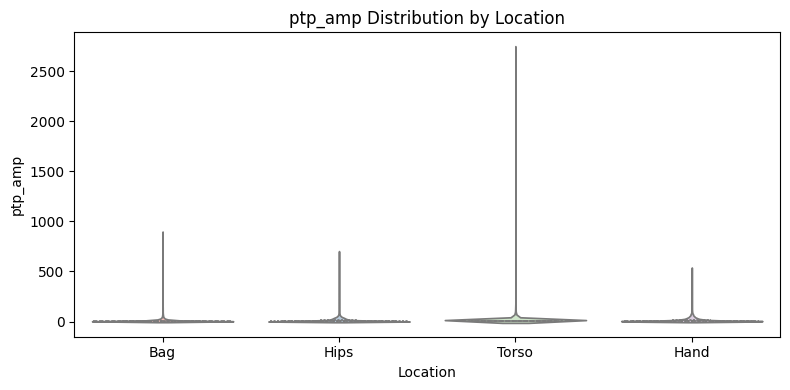

<ipython-input-27-68dd41d6412f>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='location', y=feat, data=sample_df, inner='quartile', palette='Pastel1')


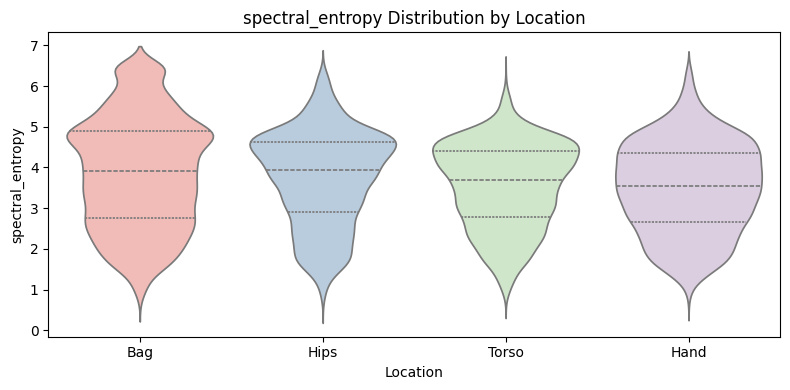

<ipython-input-27-68dd41d6412f>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='location', y=feat, data=sample_df, inner='quartile', palette='Pastel1')


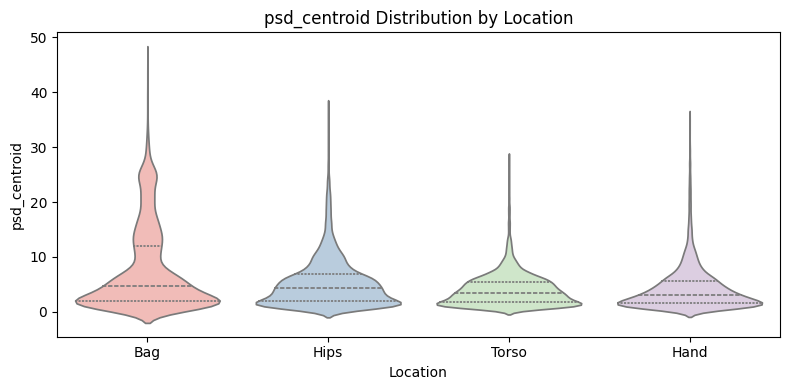

<ipython-input-27-68dd41d6412f>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='location', y=feat, data=sample_df, inner='quartile', palette='Pastel1')


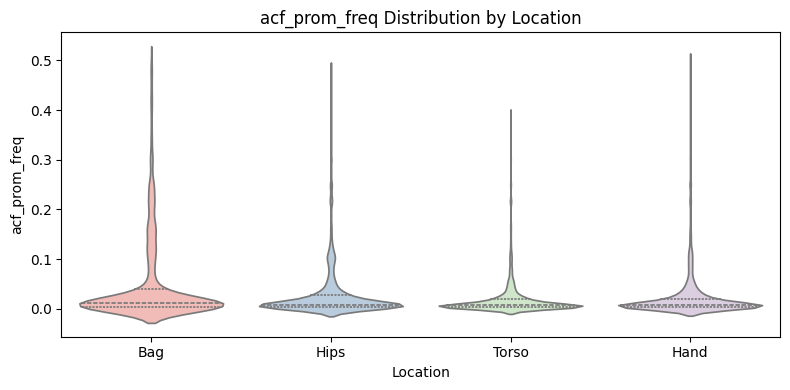

In [ ]:
# Cell 9: Feature distributions per location

# Pick a small set to visualize in detail
viz_feats = ['ptp_amp', 'spectral_entropy',
             'psd_centroid', 'acf_prom_freq']

for feat in viz_feats:
    plt.figure(figsize=(8,4))
    sns.violinplot(x='location', y=feat, data=sample_df, inner='quartile', palette='Pastel1')
    plt.title(f'{feat} Distribution by Location')
    plt.xlabel('Location')
    plt.ylabel(feat)
    plt.tight_layout()
    plt.show()


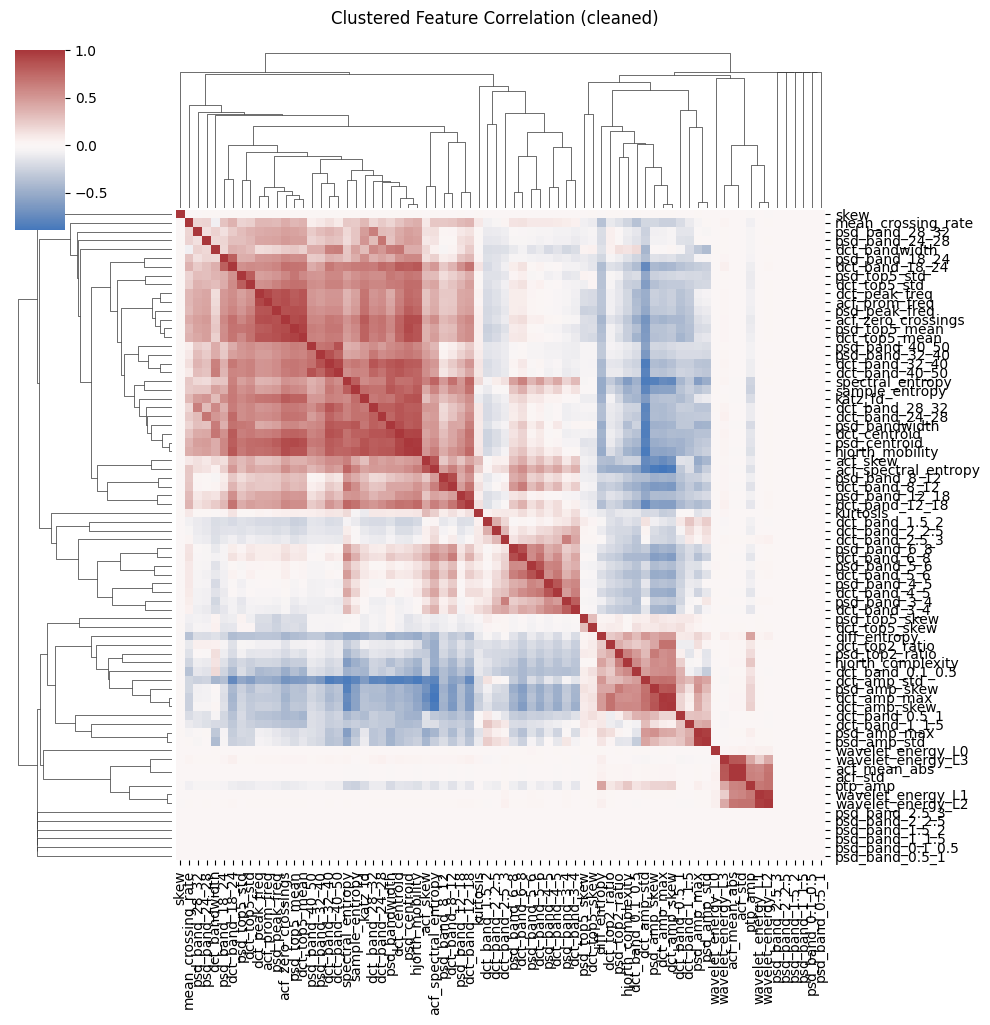

In [ ]:
# Cell 10: Clustered Heatmap of Feature Correlations (cleaned)

import numpy as np
from scipy.cluster.hierarchy import linkage  # <-- correct import :contentReference[oaicite:0]{index=0}
import scipy.spatial.distance as ssd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Compute correlation matrix and clean non-finite values
corr = sample_df[feat_cols].corr()
corr_clean = corr.replace([np.inf, -np.inf], np.nan).fillna(0)

# 2) Build dissimilarity: D = 1 - corr
diss = 1.0 - corr_clean
np.fill_diagonal(diss.values, 0)

# 3) Condense for linkage
diss_condensed = ssd.squareform(diss.values)

# 4) Perform hierarchical clustering with scipy.cluster.hierarchy.linkage :contentReference[oaicite:1]{index=1}
Z = linkage(diss_condensed, method='average')

# 5) Plot clustered heatmap
sns.clustermap(
    corr_clean,
    row_linkage=Z,
    col_linkage=Z,
    cmap='vlag',
    center=0,
    figsize=(10, 10),
    xticklabels=True,
    yticklabels=True
)
plt.suptitle('Clustered Feature Correlation (cleaned)', y=1.02)
plt.show()


In [ ]:
# Cell 11: Summary tables per location

for loc in sample_df['location'].unique():
    sub = sample_df[sample_df['location']==loc]
    print(f'\n=== Summary for {loc} (n={len(sub)}) ===')
    display(sub[feat_cols].describe().T[['mean','std','min','max']])



=== Summary for Bag (n=9000) ===


mean           std       min           max
psd_band_0.1_0.5        0.000000  0.000000e+00  0.000000  0.000000e+00
psd_band_0.5_1          0.000000  0.000000e+00  0.000000  0.000000e+00
psd_band_1_1.5          0.000000  0.000000e+00  0.000000  0.000000e+00
psd_band_1.5_2          0.000000  0.000000e+00  0.000000  0.000000e+00
psd_band_2_2.5          0.000000  0.000000e+00  0.000000  0.000000e+00
...                          ...           ...       ...           ...
wavelet_energy_L0  372673.799332  5.664502e+06  0.000011  3.850071e+08
wavelet_energy_L1     206.066885  6.580059e+03  0.000008  6.095039e+05
wavelet_energy_L2      81.852100  9.628645e+02  0.000011  7.479018e+04
wavelet_energy_L3      21.071769  1.663096e+02  0.000007  4.295494e+03
sample_entropy          0.940405  6.090304e-01  0.000158  2.785893e+00

[74 rows x 4 columns]


=== Summary for Hips (n=9000) ===


mean           std       min           max
psd_band_0.1_0.5        0.000000  0.000000e+00  0.000000  0.000000e+00
psd_band_0.5_1          0.000000  0.000000e+00  0.000000  0.000000e+00
psd_band_1_1.5          0.000000  0.000000e+00  0.000000  0.000000e+00
psd_band_1.5_2          0.000000  0.000000e+00  0.000000  0.000000e+00
psd_band_2_2.5          0.000000  0.000000e+00  0.000000  0.000000e+00
...                          ...           ...       ...           ...
wavelet_energy_L0  378485.343239  7.274993e+06  0.000189  4.761915e+08
wavelet_energy_L1     481.271541  2.335269e+03  0.000054  5.787933e+04
wavelet_energy_L2     248.059168  1.707686e+03  0.000034  5.674916e+04
wavelet_energy_L3      66.188075  6.436443e+02  0.000013  2.623764e+04
sample_entropy          0.794059  5.056904e-01  0.000211  2.554283e+00

[74 rows x 4 columns]


=== Summary for Torso (n=9000) ===


mean           std       min           max
psd_band_0.1_0.5   0.000000e+00  0.000000e+00  0.000000  0.000000e+00
psd_band_0.5_1     0.000000e+00  0.000000e+00  0.000000  0.000000e+00
psd_band_1_1.5     0.000000e+00  0.000000e+00  0.000000  0.000000e+00
psd_band_1.5_2     0.000000e+00  0.000000e+00  0.000000  0.000000e+00
psd_band_2_2.5     0.000000e+00  0.000000e+00  0.000000  0.000000e+00
...                         ...           ...       ...           ...
wavelet_energy_L0  7.621741e+06  2.339266e+08  0.001008  8.359151e+09
wavelet_energy_L1  2.481153e+03  1.468562e+05  0.000289  1.224476e+07
wavelet_energy_L2  3.175637e+02  1.532154e+04  0.000113  1.346816e+06
wavelet_energy_L3  3.992103e+01  1.984875e+03  0.000024  1.840368e+05
sample_entropy     6.938526e-01  4.040067e-01  0.001936  2.499822e+00

[74 rows x 4 columns]


=== Summary for Hand (n=9000) ===


mean           std       min           max
psd_band_0.1_0.5        0.000000  0.000000e+00  0.000000  0.000000e+00
psd_band_0.5_1          0.000000  0.000000e+00  0.000000  0.000000e+00
psd_band_1_1.5          0.000000  0.000000e+00  0.000000  0.000000e+00
psd_band_1.5_2          0.000000  0.000000e+00  0.000000  0.000000e+00
psd_band_2_2.5          0.000000  0.000000e+00  0.000000  0.000000e+00
...                          ...           ...       ...           ...
wavelet_energy_L0  189204.687530  1.114746e+06  0.000020  7.860429e+07
wavelet_energy_L1     349.122929  2.440106e+03  0.000017  8.063555e+04
wavelet_energy_L2     224.039985  2.286350e+03  0.000047  1.055981e+05
wavelet_energy_L3      51.920001  6.239487e+02  0.000021  4.051306e+04
sample_entropy          0.652266  4.618759e-01  0.001700  2.606670e+00

[74 rows x 4 columns]

# Zapisywanie Plików na Google Drive

In [ ]:
# Cell X: Parallel‐safe feature extraction with lock files

import os
import glob
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# === Settings ===
DATA_ROOT   = '/content/drive/MyDrive/Baza danych Challange Sussex 2025/train_4_locations'
OUTPUT_ROOT = '/content/drive/MyDrive/Baza danych Challange Sussex 2025/features'
LOCATIONS   = ['Bag', 'Hips', 'Torso', 'Hand']
SENSORS     = ['Acc', 'Gyr', 'Mag']
AXES        = ['x','y','z']

# Ensure output dirs
for loc in LOCATIONS:
    os.makedirs(os.path.join(OUTPUT_ROOT, loc), exist_ok=True)

def extract_features_from_file(fp):
    """Extract all windows’ features into a DataFrame."""
    data = np.loadtxt(fp)
    loc    = os.path.basename(os.path.dirname(fp))
    sensor = os.path.splitext(os.path.basename(fp))[0]
    records = []
    for i in tqdm(range(data.shape[0]),
                  desc=f'{sensor} windows',
                  position=1, leave=False):
        win = data[i]
        feats = {}
        feats.update(spectral_features(win))
        feats.update(time_acf_features(win))
        feats.update(time_signal_features(win))
        feats.update(extra_features(win))
        feats['location']    = loc
        feats['sensor_axis'] = sensor
        feats['window_id']   = i
        records.append(feats)
    return pd.DataFrame(records)

signal_files = []
for loc in LOCATIONS:
    for s in SENSORS:
        for ax in AXES:
            pattern = os.path.join(DATA_ROOT, loc, f"{s}_{ax}.txt")
            signal_files.extend(glob.glob(pattern))

for fp in tqdm(signal_files, desc='All signal files', position=0):
    loc    = os.path.basename(os.path.dirname(fp))
    sensor = os.path.splitext(os.path.basename(fp))[0]
    out_csv   = os.path.join(OUTPUT_ROOT, loc, f"{sensor}.csv")
    lock_file = out_csv + '.lock'

    # If features already exist, skip.
    if os.path.exists(out_csv):
        continue

    # If someone else is processing it, skip.
    if os.path.exists(lock_file):
        continue

    # Claim it by creating lock file
    open(lock_file, 'w').close()

    try:
        # Extract & save
        df = extract_features_from_file(fp)
        df.to_csv(out_csv, index=False)
        print(f"✔ Saved features for {sensor} → {out_csv}")
    finally:
        # Remove lock so others know it's done (or if an error occurred)
        if os.path.exists(lock_file):
            os.remove(lock_file)


All signal files:   0%|          | 0/36 [00:00<?, ?it/s]

Acc_y windows:   0%|          | 0/196072 [00:00<?, ?it/s]

✔ Saved features for Acc_y → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Bag/Acc_y.csv


Gyr_y windows:   0%|          | 0/196072 [00:00<?, ?it/s]

✔ Saved features for Gyr_y → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Bag/Gyr_y.csv


Mag_z windows:   0%|          | 0/196072 [00:00<?, ?it/s]

✔ Saved features for Mag_z → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Bag/Mag_z.csv


Gyr_x windows:   0%|          | 0/196072 [00:00<?, ?it/s]

✔ Saved features for Gyr_x → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Hips/Gyr_x.csv


Mag_y windows:   0%|          | 0/196072 [00:00<?, ?it/s]

✔ Saved features for Mag_y → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Hips/Mag_y.csv


Acc_z windows:   0%|          | 0/196072 [00:00<?, ?it/s]

✔ Saved features for Acc_z → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Torso/Acc_z.csv


Gyr_z windows:   0%|          | 0/196072 [00:00<?, ?it/s]

✔ Saved features for Gyr_z → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Torso/Gyr_z.csv


Mag_y windows:   0%|          | 0/196072 [00:00<?, ?it/s]

✔ Saved features for Mag_y → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Torso/Mag_y.csv


Acc_x windows:   0%|          | 0/196072 [00:00<?, ?it/s]

✔ Saved features for Acc_x → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Hand/Acc_x.csv


Gyr_z windows:   0%|          | 0/196072 [00:00<?, ?it/s]

✔ Saved features for Gyr_z → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Hand/Gyr_z.csv


Mag_z windows:   0%|          | 0/196072 [00:00<?, ?it/s]

✔ Saved features for Mag_z → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Hand/Mag_z.csv


# Adding the mode of transport to teh files

In [3]:
df=pd.read_csv('/content/drive/MyDrive/Baza danych Challange Sussex 2025/train_4_locations/Bag/Label.txt', header=None, delimiter=' ')
df

0    1    2    3    4    5    6    7    8    9    ...  490  491  492  \
0         4    4    4    4    4    4    4    4    4    4  ...    4    4    4   
1         4    4    4    4    4    4    4    4    4    4  ...    4    4    4   
2         4    4    4    4    4    4    4    4    4    4  ...    4    4    4   
3         4    4    4    4    4    4    4    4    4    4  ...    4    4    4   
4         4    4    4    4    4    4    4    4    4    4  ...    4    4    4   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
196067    5    5    5    5    5    5    5    5    5    5  ...    5    5    5   
196068    5    5    5    5    5    5    5    5    5    5  ...    5    5    5   
196069    5    5    5    5    5    5    5    5    5    5  ...    5    5    5   
196070    5    5    5    5    5    5    5    5    5    5  ...    5    5    5   
196071    5    5    5    5    5    5    5    5    5    5  ...    5    5    5   

        493  494  495  496  497  498  499  
0         4    4    4    4    4    4    4  
1         4    4    4    4    4    4    4  
2         4    4    4    4    4    4    4  
3         4    4    4    4    4    4    4  
4         4    4    4    4    4    4    4  
...     ...  ...  ...  ...  ...  ...  ...  
196067    5    5    5    5    5    5    5  
196068    5    5    5    5    5    5    5  
196069    5    5    5    5    5    5    5  
196070    5    5    5    5    5    5    5  
196071    5    5    5    5    5    5    5  

[196072 rows x 500 columns]

In [4]:
df_np = np.array(df)
row_modes = []

for row in df_np:
    values, counts = np.unique(row, return_counts=True)

    most_frequent_value = values[np.argmax(counts)]
    row_modes.append(most_frequent_value)

print(row_modes[1])


4


In [5]:
# Cell X: Add 'mode' only if missing (raw + sensor fusion) with lock files

import os
import glob
import pandas as pd
from tqdm.auto import tqdm

# === Settings ===
DATA_ROOT      = '/content/drive/MyDrive/Baza danych Challange Sussex 2025/features'
LOCATIONS      = ['Bag', 'Hips', 'Torso', 'Hand']
RAW_SENSORS    = ['Acc', 'Gyr', 'Mag']
RAW_AXES       = ['x', 'y', 'z']
FUSION_SENSORS = ['Acc_rot_x', 'Acc_rot_y', 'Acc_rot_z', 'Acc_solo_mag']

# Assume row_modes is defined and contains the correct mode for each window
# e.g. row_modes = [...]

# Collect all feature files
signal_files = []
for loc in LOCATIONS:
    for s in RAW_SENSORS:
        for ax in RAW_AXES:
            pattern = os.path.join(DATA_ROOT, loc, f"{s}_{ax}.csv")
            signal_files.extend(glob.glob(pattern))
    for fs in FUSION_SENSORS:
        pattern = os.path.join(DATA_ROOT, loc, f"{fs}.csv")
        signal_files.extend(glob.glob(pattern))

# Process each file
for fp in tqdm(signal_files, desc='All signal files', position=0):
    sensor   = os.path.splitext(os.path.basename(fp))[0]
    lock_file = fp + '.lock'

    # skip if already locked
    if os.path.exists(lock_file):
        continue

    # check header for 'mode'
    df_header = pd.read_csv(fp, nrows=0)
    if 'mode' in df_header.columns:
        continue

    # claim lock
    open(lock_file, 'w').close()
    try:
        # read full file, add mode column
        df_temp = pd.read_csv(fp)
        for i in range(len(df_temp)):
            df_temp.loc[i, 'mode'] = row_modes[i]
        df_temp.to_csv(fp, index=False)
        print(f"✔ Added mode to {sensor} → {fp}")
    finally:
        if os.path.exists(lock_file):
            os.remove(lock_file)


All signal files:   0%|          | 0/52 [00:00<?, ?it/s]

✔ Added mode to Acc_rot_x → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Bag/Acc_rot_x.csv
✔ Added mode to Acc_rot_y → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Bag/Acc_rot_y.csv
✔ Added mode to Acc_rot_z → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Bag/Acc_rot_z.csv
✔ Added mode to Acc_solo_mag → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Bag/Acc_solo_mag.csv
✔ Added mode to Acc_rot_x → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Hips/Acc_rot_x.csv
✔ Added mode to Acc_rot_y → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Hips/Acc_rot_y.csv
✔ Added mode to Acc_rot_z → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Hips/Acc_rot_z.csv
✔ Added mode to Acc_solo_mag → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Hips/Acc_solo_mag.csv
✔ Added mode to Acc_rot_x → /content/drive/MyDrive/Baza danych Challange Sussex 2025/fea

In [6]:
!zip -r /content/features.zip "/content/drive/MyDrive/Baza danych Challange Sussex 2025/features"

  adding: content/drive/MyDrive/Baza danych Challange Sussex 2025/features/ (stored 0%)
  adding: content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Bag/ (stored 0%)
  adding: content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Bag/Acc_x.csv (deflated 55%)
  adding: content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Bag/Acc_y.csv (deflated 55%)
  adding: content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Bag/Acc_z.csv (deflated 54%)
  adding: content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Bag/Gyr_x.csv (deflated 55%)
  adding: content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Bag/Gyr_y.csv (deflated 55%)
  adding: content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Bag/Gyr_z.csv (deflated 55%)
  adding: content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Bag/Mag_x.csv (deflated 55%)
  adding: content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Bag/Mag_y.csv (de

In [7]:
from google.colab import files
files.download('/content/features.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Code ammended to include sensor_fusion data

In [13]:
# Cell X: Parallel‐safe feature extraction over two data sources,
# preserving blank lines as NaN‐only feature rows, and printing output shape.

import os
import glob
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# === Settings ===
DATA_ROOTS = {
    'raw':    '/content/drive/MyDrive/Baza danych Challange Sussex 2025/train_4_locations',
    'fusion': '/content/drive/MyDrive/Baza danych Challange Sussex 2025/sensor_fusion/train'
}
OUTPUT_ROOT = '/content/drive/MyDrive/Baza danych Challange Sussex 2025/features'
LOCATIONS   = ['Bag', 'Hips', 'Torso', 'Hand']

RAW_SENSORS    = ['Acc', 'Gyr', 'Mag']
RAW_AXES       = ['x', 'y', 'z']
FUSION_SENSORS = ['Acc_rot_x', 'Acc_rot_y', 'Acc_rot_z', 'Acc_solo_mag']

# Ensure output directories exist
for loc in LOCATIONS:
    os.makedirs(os.path.join(OUTPUT_ROOT, loc), exist_ok=True)


def extract_features_from_file(fp):
    """
    Read `fp` line by line (so blank lines are preserved).
    For each line:
      - If blank, emit NaN for every feature.
      - Otherwise, run the four feature‐extraction functions.
    Always include 'location', 'sensor_axis', 'window_id'.
    """
    # 1) Read all lines (including blank ones)
    with open(fp, 'r') as f:
        lines = f.readlines()

    # 2) Find the first non-blank to discover feature names
    first_vals = None
    for l in lines:
        if l.strip():
            first_vals = np.fromstring(l, sep=' ')
            break
    if first_vals is None:
        raise ValueError(f"No valid data lines in {fp!r}")

    # 3) Build a template dict to get feature column names
    template = {}
    template.update(spectral_features(first_vals))
    template.update(time_acf_features(first_vals))
    template.update(time_signal_features(first_vals))
    template.update(extra_features(first_vals))
    feature_keys = list(template.keys())

    # 4) Iterate every line and fill features (or NaNs)
    loc    = os.path.basename(os.path.dirname(fp))
    sensor = os.path.splitext(os.path.basename(fp))[0]
    records = []

    for i, raw in enumerate(tqdm(lines,
                                 desc=f'{sensor} windows',
                                 position=1,
                                 leave=False)):
        feats = {}
        if not raw.strip():
            # blank → NaN for every feature
            for k in feature_keys:
                feats[k] = np.nan
        else:
            win = np.fromstring(raw.strip(), sep=' ')
            feats.update(spectral_features(win))
            feats.update(time_acf_features(win))
            feats.update(time_signal_features(win))
            feats.update(extra_features(win))

        # metadata columns
        feats['location']    = loc
        feats['sensor_axis'] = sensor
        feats['window_id']   = i

        records.append(feats)

    return pd.DataFrame(records)


# 5) Gather all .txt files
signal_files = []

# raw sensors
for loc in LOCATIONS:
    for sensor in RAW_SENSORS:
        for ax in RAW_AXES:
            pattern = os.path.join(DATA_ROOTS['raw'], loc, f"{sensor}_{ax}.txt")
            signal_files.extend(glob.glob(pattern))

# fusion sensors
for loc in LOCATIONS:
    for sensor in FUSION_SENSORS:
        pattern = os.path.join(DATA_ROOTS['fusion'], loc, f"{sensor}.txt")
        signal_files.extend(glob.glob(pattern))


# 6) Process with lock files and print output shape
for fp in tqdm(signal_files, desc='All signal files', position=0):
    loc    = os.path.basename(os.path.dirname(fp))
    sensor = os.path.splitext(os.path.basename(fp))[0]
    out_csv   = os.path.join(OUTPUT_ROOT, loc, f"{sensor}.csv")
    lock_file = out_csv + '.lock'

    if os.path.exists(out_csv) or os.path.exists(lock_file):
        continue

    # claim it
    open(lock_file, 'w').close()
    try:
        df = extract_features_from_file(fp)
        df.to_csv(out_csv, index=False)
        print(f"✔ Saved features for {sensor} → {out_csv}")
        print(f"   → Output shape: {df.shape}")  # rows, cols
    finally:
        if os.path.exists(lock_file):
            os.remove(lock_file)


All signal files:   0%|          | 0/52 [00:00<?, ?it/s]

Acc_rot_y windows:   0%|          | 0/196072 [00:00<?, ?it/s]

✔ Saved features for Acc_rot_y → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Bag/Acc_rot_y.csv
   → Output shape: (196072, 77)


Acc_rot_y windows:   0%|          | 0/196072 [00:00<?, ?it/s]

✔ Saved features for Acc_rot_y → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Hips/Acc_rot_y.csv
   → Output shape: (196072, 77)


Acc_rot_z windows:   0%|          | 0/196072 [00:00<?, ?it/s]

✔ Saved features for Acc_rot_z → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Torso/Acc_rot_z.csv
   → Output shape: (196072, 77)


# Simple RandomForest CLassifier

In [ ]:
# Cell 1: Imports
import os
import glob
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# === Settings ===
DATA_ROOT = '/content/drive/MyDrive/Baza danych Challange Sussex 2025/features'
glob_pattern = os.path.join(DATA_ROOT, '*', '*.csv')

# === 1. Load + Concatenate All Feature CSVs (with tqdm) ===
all_files = glob.glob(glob_pattern)
print(f"Found {len(all_files)} feature files.")  # Should be 36

dfs = []
for fp in tqdm(all_files, desc='Loading feature CSVs', unit='file'):
    df_tmp = pd.read_csv(fp)
    dfs.append(df_tmp)

df_all = pd.concat(dfs, axis=0, ignore_index=True)
df_all = df_all.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle

print("Combined shape (before sampling):", df_all.shape)
print("Mode distribution:\n", df_all['mode'].value_counts())

# === 2. Take a 10% Random Sample (for speed) ===
df_sample = df_all.sample(frac=0.010, random_state=42).reset_index(drop=True)
print("Sampled shape (10%):", df_sample.shape)
print("Mode distribution in sample:\n", df_sample['mode'].value_counts())

# === 3. One-Hot Encode 'location' and 'sensor_axis' ===
df_encoded = pd.get_dummies(
    df_sample.drop(columns=['mode']),
    columns=['location', 'sensor_axis'],
    prefix=['loc', 'axis'],
    drop_first=False,
    dtype=np.uint8
)
print("Shape after one-hot encoding:", df_encoded.shape)

# === 4. Split into Features (X) and Target (y) ===
X = df_encoded
y = df_sample['mode']

# === 5. Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)
print("Training size:", X_train.shape, "| Testing size:", X_test.shape)

# === 6a. Train a Larger Random Forest ===
rf_large = RandomForestClassifier(
    n_estimators=10,       # More trees
    max_depth=20,           # Limit depth to prevent overfitting
    random_state=42,
    n_jobs=-1,
    verbose=1               # Show per-tree progress
)
print("\nTraining Random Forest with n_estimators=200, max_depth=20 …")
rf_large.fit(X_train, y_train)


# === 7a. Evaluate Random Forest ===
y_pred_rf = rf_large.predict(X_test)
print("\n=== Random Forest: Classification Report ===")
print(classification_report(y_test, y_pred_rf, digits=4))
print("=== Random Forest: Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred_rf))


# === 6b. Train a Gradient Boosting Classifier ===
gbt = GradientBoostingClassifier(
    n_estimators=10,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    verbose=1
)
print("\nTraining Gradient Boosting (n_estimators=100, learning_rate=0.1, max_depth=5) …")
gbt.fit(X_train, y_train)



# === 7b. Evaluate Gradient Boosting ===
y_pred_gbt = gbt.predict(X_test)
print("\n=== Gradient Boosting: Classification Report ===")
print(classification_report(y_test, y_pred_gbt, digits=4))
print("=== Gradient Boosting: Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred_gbt))


Found 36 feature files.


Loading feature CSVs:   0%|          | 0/36 [00:00<?, ?file/s]

Combined shape (before sampling): (7058592, 78)
Mode distribution:
 mode
5.0    1142388
7.0    1125108
6.0    1019736
2.0     883584
1.0     880416
8.0     858024
4.0     845028
3.0     304308
Name: count, dtype: int64
Sampled shape (10%): (70586, 78)
Mode distribution in sample:
 mode
7.0    11347
5.0    11215
6.0    10281
2.0     8853
1.0     8735
8.0     8603
4.0     8526
3.0     3026
Name: count, dtype: int64
Shape after one-hot encoding: (70586, 88)
Training size: (56468, 88) | Testing size: (14118, 88)

Training Random Forest with n_estimators=200, max_depth=20 …


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished



=== Random Forest: Classification Report ===
              precision    recall  f1-score   support

         1.0     0.5170    0.5318    0.5243      1747
         2.0     0.6922    0.7239    0.7077      1771
         3.0     0.8852    0.7901    0.8349       605
         4.0     0.6659    0.6393    0.6523      1705
         5.0     0.6193    0.6549    0.6366      2243
         6.0     0.5013    0.4859    0.4935      2056
         7.0     0.4124    0.4586    0.4343      2270
         8.0     0.3336    0.2719    0.2996      1721

    accuracy                         0.5494     14118
   macro avg     0.5784    0.5695    0.5729     14118
weighted avg     0.5475    0.5494    0.5476     14118

=== Random Forest: Confusion Matrix ===
[[ 929   23    0   22  121  180  279  193]
 [  23 1282   17  190   45   46   93   75]
 [   0   46  478   61    6    3    9    2]
 [  25  254   23 1090   76   75  100   62]
 [ 132   70   11   56 1469  291  135   79]
 [ 190   45    2   49  371  999  270  130]
 [ 26


Training Random Forest with n_estimators=200, max_depth=20 …


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished



=== Random Forest: Classification Report ===
              precision    recall  f1-score   support

         1.0     0.5758    0.6045    0.5898      1747
         2.0     0.7697    0.7815    0.7756      1771
         3.0     0.9461    0.8413    0.8906       605
         4.0     0.7351    0.7015    0.7179      1705
         5.0     0.6762    0.7205    0.6976      2243
         6.0     0.5676    0.5516    0.5594      2056
         7.0     0.4564    0.5423    0.4957      2270
         8.0     0.4159    0.2987    0.3476      1721

    accuracy                         0.6120     14118
   macro avg     0.6428    0.6302    0.6343     14118
weighted avg     0.6113    0.6120    0.6095     14118

=== Random Forest: Confusion Matrix ===
[[1056   19    0   17   90  181  245  139]
 [  19 1384    6  141   35   42   78   66]
 [   0   35  509   43    8    0    9    1]
 [  23  194   14 1196   64   53   95   66]
 [ 113   36    6   54 1616  232  136   50]
 [ 172   33    2   40  323 1134  258   94]
 [ 24

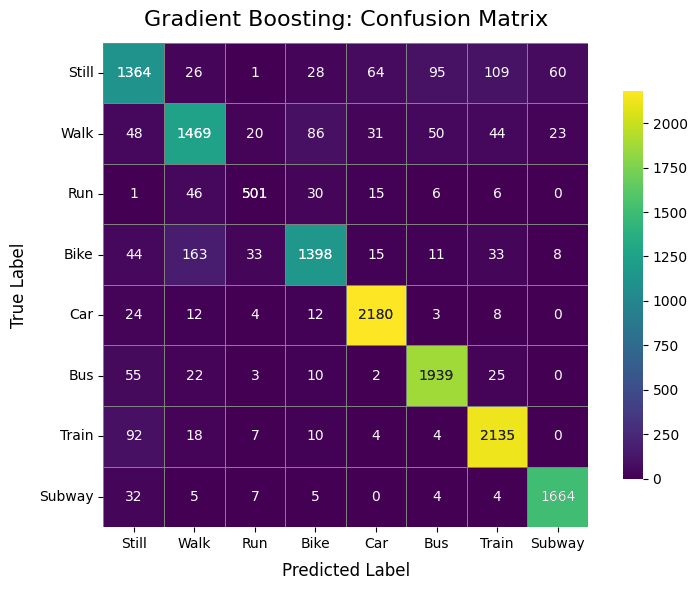

In [ ]:
import seaborn as sns
labels = ["Still","Walk","Run","Bike","Car","Bus","Train","Subway"]
cmap_choice = plt.cm.viridis


# === 6a. Train a Larger Random Forest ===
rf_large = RandomForestClassifier(
    n_estimators=100,       # More trees
    max_depth=50,           # Limit depth to prevent overfitting
    random_state=42,
    n_jobs=-1,
    verbose=1               # Show per-tree progress
)
print("\nTraining Random Forest with n_estimators=200, max_depth=20 …")
rf_large.fit(X_train, y_train)


# === 7a. Evaluate Random Forest ===
y_pred_rf = rf_large.predict(X_test)
print("\n=== Random Forest: Classification Report ===")
print(classification_report(y_test, y_pred_rf, digits=4))
print("=== Random Forest: Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred_rf))


# === 6b. Train a Gradient Boosting Classifier ===
gbt = GradientBoostingClassifier(
    n_estimators=12,
    learning_rate=0.3,
    max_depth=7,
    random_state=42,
    verbose=1
)
print("\nTraining Gradient Boosting (n_estimators=12, learning_rate=0.3, max_depth=7) …")
gbt.fit(X_train, y_train)



# === 7b. Evaluate Gradient Boosting ===
y_pred_gbt = gbt.predict(X_test)
print("\n=== Gradient Boosting: Classification Report ===")
print(classification_report(y_test, y_pred_gbt, digits=4))

# Plot the GBT confusion matrix similarly
cm_gbt = confusion_matrix(y_test, y_pred_gbt)  # 8×8 array
cm_gbt_df = pd.DataFrame(cm_gbt, index=labels, columns=labels)

fig2, ax2 = plt.subplots(figsize=(8, 6), dpi=100)
sns.heatmap(
    cm_gbt_df,
    annot=True,
    fmt="d",
    cmap=cmap_choice,
    linewidths=0.5,
    linecolor="gray",
    square=True,
    cbar_kws={"shrink": 0.8},
    ax=ax2
)

mask2 = np.zeros_like(cm_gbt_df, dtype=bool)
for i in range(len(cm_gbt_df)):
    for j in range(len(cm_gbt_df)):
        if i != j:
            mask2[i, j] = True

sns.heatmap(
    cm_gbt_df,
    mask=mask2,
    cmap=cmap_choice,
    annot=True,
    fmt="d",
    linewidths=0.5,
    linecolor="gray",
    square=True,
    cbar=False,
    ax=ax2
)

ax2.set_title("Gradient Boosting: Confusion Matrix", fontsize=16, pad=12)
ax2.set_xlabel("Predicted Label", fontsize=12, labelpad=8)
ax2.set_ylabel("True Label", fontsize=12, labelpad=8)

ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, fontsize=10)
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

# Above had the issue of window_id not being excluded, and it learned that specific window_id ranges differ in transport, just because they are sequentially given from beginning to end of recording

# More Data **1% -> 5%**

In [ ]:
pip install --q xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 MB 3.4 MB/s eta 0:00:00


Found 36 feature files.


Loading feature CSVs:   0%|          | 0/36 [00:00<?, ?file/s]

Combined shape (before sampling): (7058592, 78)
Mode distribution:
 mode
5.0    1142388
7.0    1125108
6.0    1019736
2.0     883584
1.0     880416
8.0     858024
4.0     845028
3.0     304308
Name: count, dtype: int64
Sampled shape (5%): (352930, 78)
Mode distribution in sample:
 mode
5.0    56841
7.0    56242
6.0    51077
2.0    44378
1.0    43944
8.0    42867
4.0    42407
3.0    15174
Name: count, dtype: int64
Shape after one-hot encoding (and dropping window_id): (352930, 78)
Training size: (282344, 78) | Testing size: (70586, 78)

Training XGBoost (n_estimators=80, max_depth=8, learning_rate=0.1) …


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:06:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost: Classification Report ===
              precision    recall  f1-score   support

           0     0.5535    0.6467    0.5965      8789
           1     0.8279    0.8220    0.8249      8876
           2     0.9510    0.9265    0.9386      3035
           3     0.7720    0.7704    0.7712      8481
           4     0.6836    0.7293    0.7057     11368
           5     0.5975    0.5709    0.5839     10215
           6     0.4930    0.5057    0.4993     11249
           7     0.4276    0.3319    0.3737      8573

    accuracy                         0.6373     70586
   macro avg     0.6632    0.6629    0.6617     70586
weighted avg     0.6337    0.6373    0.6341     70586



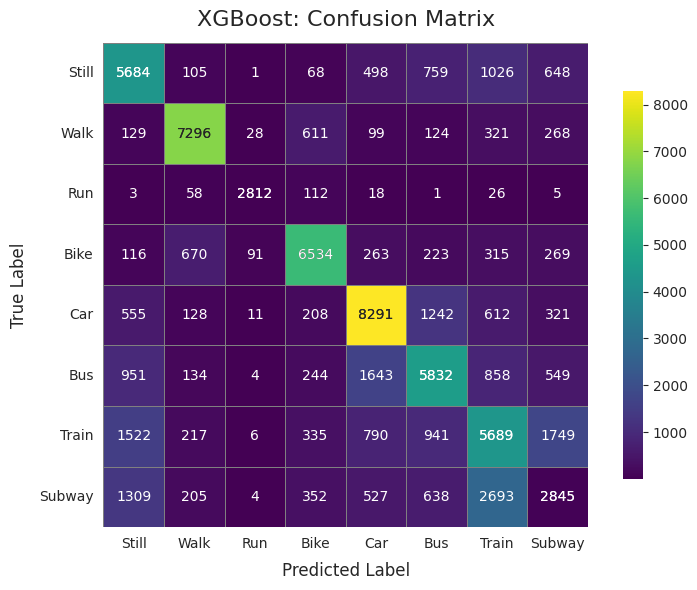


Top 10 Features – XGBoost (by gain):
              feature  importance
0        diff_entropy    0.063238
1             acf_std    0.060023
2       psd_peak_freq    0.057823
3       dct_peak_freq    0.048737
4             ptp_amp    0.038132
5   wavelet_energy_L1    0.036341
6        acf_mean_abs    0.034272
7  mean_crossing_rate    0.034255
8      sample_entropy    0.030987
9         dct_amp_std    0.030615


<ipython-input-17-8ca34407ba05>:283: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


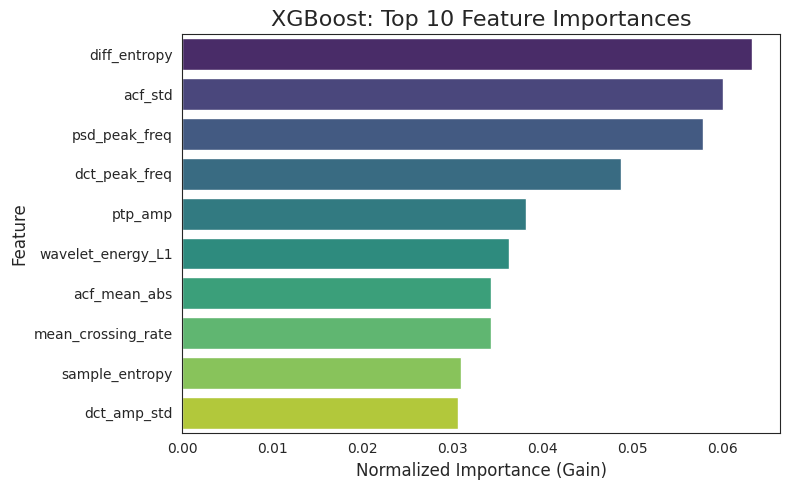

In [ ]:
# Cell 1: Imports
import os
import glob
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# Machine Learning Imports
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import xgboost as xgb

# Plotting Imports
import matplotlib.pyplot as plt
import seaborn as sns

# === Settings ===
DATA_ROOT = '/content/drive/MyDrive/Baza danych Challange Sussex 2025/features'
glob_pattern = os.path.join(DATA_ROOT, '*', '*.csv')

# === 1. Load + Concatenate All Feature CSVs (with tqdm) ===
all_files = glob.glob(glob_pattern)
print(f"Found {len(all_files)} feature files.")  # Expect 36

dfs = []
for fp in tqdm(all_files, desc='Loading feature CSVs', unit='file'):
    df_tmp = pd.read_csv(fp)   # Each CSV: numeric features + 'location' + 'sensor_axis' + 'mode'
    dfs.append(df_tmp)

df_all = pd.concat(dfs, axis=0, ignore_index=True)
df_all = df_all.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle

print("Combined shape (before sampling):", df_all.shape)
print("Mode distribution:\n", df_all['mode'].value_counts())

# === 2. Take a 5% Random Sample (for speed) ===
df_sample = df_all.sample(frac=0.05, random_state=42).reset_index(drop=True)
print("Sampled shape (5%):", df_sample.shape)
print("Mode distribution in sample:\n", df_sample['mode'].value_counts())

# === 3. One-Hot Encode 'location' and 'sensor_axis' ===
df_encoded = pd.get_dummies(
    df_sample.drop(columns=['mode', 'sensor_axis']),
    columns=['location'],
    prefix=['loc'],
    drop_first=False,
    dtype=np.uint8
).drop(columns=['window_id'])  # ← drop window_id here

print("Shape after one-hot encoding (and dropping window_id):", df_encoded.shape)

# === 4. Split into Features (X) and Target (y) ===
X = df_encoded
y = df_sample['mode']

# === 5. Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)
print("Training size:", X_train.shape, "| Testing size:", X_test.shape)

# Pre-define plotting parameters and labels
labels = ["Still","Walk","Run","Bike","Car","Bus","Train","Subway"]
sns.set_style("white")
cmap_choice = plt.cm.viridis


'''
# === 6a. Train a Random Forest ===
rf_large = RandomForestClassifier(
    n_estimators=100,      # More trees for better generalization
    max_depth=50,          # Limit depth to reduce overfitting
    random_state=42,
    n_jobs=-1,
    verbose=1              # Show per-tree progress
)
print("\nTraining Random Forest (n_estimators=100, max_depth=50) …")
rf_large.fit(X_train, y_train)  # Already-fitted model stores feature_importances_

# === 7a. Evaluate Random Forest ===
y_pred_rf = rf_large.predict(X_test)
print("\n=== Random Forest: Classification Report ===")
print(classification_report(y_test, y_pred_rf, digits=4))

# Plot RF confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_rf_df = pd.DataFrame(cm_rf, index=labels, columns=labels)

fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
sns.heatmap(
    cm_rf_df,
    annot=True,
    fmt="d",
    cmap=cmap_choice,
    linewidths=0.5,
    linecolor="gray",
    square=True,
    cbar_kws={"shrink": 0.8},
    ax=ax
)

mask = np.zeros_like(cm_rf_df, dtype=bool)
for i in range(len(cm_rf_df)):
    for j in range(len(cm_rf_df)):
        if i != j:
            mask[i, j] = True

sns.heatmap(
    cm_rf_df,
    mask=mask,
    cmap=cmap_choice,
    annot=True,
    fmt="d",
    linewidths=0.5,
    linecolor="gray",
    square=True,
    cbar=False,
    ax=ax
)

ax.set_title("Random Forest: Confusion Matrix", fontsize=16, pad=12)
ax.set_xlabel("Predicted Label", fontsize=12, labelpad=8)
ax.set_ylabel("True Label", fontsize=12, labelpad=8)

ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

# === 6b. Train a Gradient Boosting Classifier ===
gbt = GradientBoostingClassifier(
    n_estimators=12,
    learning_rate=0.3,
    max_depth=7,
    random_state=42,
    verbose=1
)
print("\nTraining Gradient Boosting (n_estimators=12, learning_rate=0.3, max_depth=7) …")
gbt.fit(X_train, y_train)

# === 7b. Evaluate Gradient Boosting ===
y_pred_gbt = gbt.predict(X_test)
print("\n=== Gradient Boosting: Classification Report ===")
print(classification_report(y_test, y_pred_gbt, digits=4))

# Plot GBT confusion matrix
cm_gbt = confusion_matrix(y_test, y_pred_gbt)
cm_gbt_df = pd.DataFrame(cm_gbt, index=labels, columns=labels)

fig2, ax2 = plt.subplots(figsize=(8, 6), dpi=100)
sns.heatmap(
    cm_gbt_df,
    annot=True,
    fmt="d",
    cmap=cmap_choice,
    linewidths=0.5,
    linecolor="gray",
    square=True,
    cbar_kws={"shrink": 0.8},
    ax=ax2
)

mask2 = np.zeros_like(cm_gbt_df, dtype=bool)
for i in range(len(cm_gbt_df)):
    for j in range(len(cm_gbt_df)):
        if i != j:
            mask2[i, j] = True

sns.heatmap(
    cm_gbt_df,
    mask=mask2,
    cmap=cmap_choice,
    annot=True,
    fmt="d",
    linewidths=0.5,
    linecolor="gray",
    square=True,
    cbar=False,
    ax=ax2
)

ax2.set_title("Gradient Boosting: Confusion Matrix", fontsize=16, pad=12)
ax2.set_xlabel("Predicted Label", fontsize=12, labelpad=8)
ax2.set_ylabel("True Label", fontsize=12, labelpad=8)

ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, fontsize=10)
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0, fontsize=10)

plt.tight_layout()
plt.show()
'''





# === 9. XGBoost ===
# Encode y labels from 1–8 to 0–7 for XGBoost compatibility
y_train_enc = y_train.astype(int) - 1
y_test_enc  = y_test.astype(int)  - 1

xgb_model = xgb.XGBClassifier(
    booster='gbtree',
    n_estimators=80,
    max_depth=8,
    learning_rate=0.3,
    random_state=42,
    n_jobs=-1,
    verbose =1
)
print("\nTraining XGBoost (n_estimators=80, max_depth=8, learning_rate=0.1) …")
xgb_model.fit(X_train, y_train_enc)

# XGB Evaluation (on encoded labels)
y_pred_xgb_enc = xgb_model.predict(X_test)
print("\n=== XGBoost: Classification Report ===")
print(classification_report(y_test_enc, y_pred_xgb_enc, digits=4))

# Build confusion matrix and map back to original class names
cm_xgb = confusion_matrix(y_test_enc, y_pred_xgb_enc)
cm_xgb_df = pd.DataFrame(cm_xgb, index=labels, columns=labels)

fig3, ax3 = plt.subplots(figsize=(8, 6), dpi=100)
sns.heatmap(
    cm_xgb_df,
    annot=True,
    fmt="d",
    cmap=cmap_choice,
    linewidths=0.5,
    linecolor="gray",
    square=True,
    cbar_kws={"shrink": 0.8},
    ax=ax3
)
mask3 = np.zeros_like(cm_xgb_df, dtype=bool)
for i in range(len(cm_xgb_df)):
    for j in range(len(cm_xgb_df)):
        if i != j:
            mask3[i, j] = True

sns.heatmap(
    cm_xgb_df,
    mask=mask3,
    cmap=cmap_choice,
    annot=True,
    fmt="d",
    linewidths=0.5,
    linecolor="gray",
    square=True,
    cbar=False,
    ax=ax3
)
ax3.set_title("XGBoost: Confusion Matrix", fontsize=16, pad=12)
ax3.set_xlabel("Predicted Label", fontsize=12, labelpad=8)
ax3.set_ylabel("True Label", fontsize=12, labelpad=8)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0, fontsize=10)
ax3.set_yticklabels(ax3.get_yticklabels(), rotation=0, fontsize=10)
plt.tight_layout()
plt.show()




# === 10. XGBoost Feature Importances (no retraining) ===
xgb_importances = xgb_model.feature_importances_
feature_names = X_train.columns.tolist()

importance_df_xgb = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_importances
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

print("\nTop 10 Features – XGBoost (by gain):")
print(importance_df_xgb.head(10))

plt.figure(figsize=(8, 5), dpi=100)
sns.barplot(
    data=importance_df_xgb.head(10),
    x='importance',
    y='feature',
    palette='viridis'
)
plt.title("XGBoost: Top 10 Feature Importances", fontsize=16)
plt.xlabel("Normalized Importance (Gain)", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

# Test with sensor_fusion

In [10]:
pip install --q xgboost seaborn ipywidgets==7.7.5



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install --upgrade ipywidgets==7.7.5
!pip install --upgrade jupyterlab>=4.0
!pip install --upgrade ipywidgets

Defaulting to user installation because normal site-packages is not writeable
  Using cached ipywidgets-7.7.5-py2.py3-none-any.whl.metadata (1.9 kB)
  Using cached widgetsnbextension-3.6.10-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached jupyterlab_widgets-1.1.11-py3-none-any.whl.metadata (3.7 kB)
Using cached ipywidgets-7.7.5-py2.py3-none-any.whl (123 kB)
Using cached jupyterlab_widgets-1.1.11-py3-none-any.whl (246 kB)
Using cached widgetsnbextension-3.6.10-py2.py3-none-any.whl (1.6 MB)

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
poetry 1.1.13 requires packaging<21.0,>=20.4, but you have packaging 25.0 which is incompatible.
virtualenv 20.14.1 requires platformdirs<3,>=2, but you have platformdirs 4.3.8 which is incompatible.

[notice] A new

In [7]:
from tqdm.auto import tqdm
a=0
for i in tqdm(range(1,1000,1)):
              a=a+2
print(a)

  0%|          | 0/999 [00:00<?, ?it/s]

1998


In [6]:
print("Done")

Done


import complete
Found 52 feature files.


Loading feature CSVs:   0%|          | 0/52 [00:00<?, ?file/s]

Read file number 1
Read file number 2
Read file number 3
Read file number 4
Read file number 5
Read file number 6
Read file number 7
Read file number 8
Read file number 9
Read file number 10
Read file number 11
Read file number 12
Read file number 13
Read file number 14
Read file number 15
Read file number 16
Read file number 17
Read file number 18
Read file number 19
Read file number 20
Read file number 21
Read file number 22
Read file number 23
Read file number 24
Read file number 25
Read file number 26
Read file number 27
Read file number 28
Read file number 29
Read file number 30
Read file number 31
Read file number 32
Read file number 33
Read file number 34
Read file number 35
Read file number 36
Read file number 37
Read file number 38
Read file number 39
Read file number 40
Read file number 41
Read file number 42
Read file number 43
Read file number 44
Read file number 45
Read file number 46
Read file number 47
Read file number 48
Read file number 49
Read file number 50
Read file

/net/people/plgrid/plgdusza/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:42:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost: Classification Report ===
              precision    recall  f1-score   support

           0     0.7083    0.8500    0.7727        20
           1     0.8500    0.8947    0.8718        19
           2     1.0000    0.8333    0.9091         6
           3     1.0000    0.7857    0.8800        14
           4     0.7000    0.8400    0.7636        25
           5     0.5789    0.4231    0.4889        26
           6     0.5517    0.6667    0.6038        24
           7     0.4737    0.3913    0.4286        23

    accuracy                         0.6815       157
   macro avg     0.7328    0.7106    0.7148       157
weighted avg     0.6816    0.6815    0.6748       157



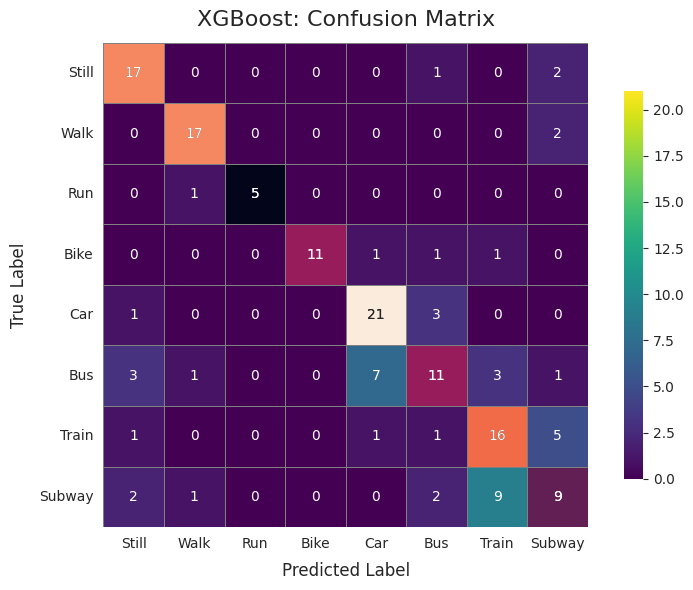


Top 10 Features – XGBoost:
                    feature  importance
0   Hand_Gyr_x_acf_mean_abs    0.021619
1        Hips_Mag_y_ptp_amp    0.021488
2  Torso_Gyr_z_psd_band_5_6    0.016191
3    Bag_Mag_x_psd_centroid    0.016050
4  Torso_Mag_y_diff_entropy    0.015189
5  Hips_Acc_y_psd_peak_freq    0.012976
6        Hand_Gyr_x_katz_fd    0.012013
7    Bag_Gyr_y_diff_entropy    0.011611
8   Torso_Acc_z_psd_amp_std    0.011576
9  Hand_Mag_y_psd_bandwidth    0.010892


/net/tscratch/people/plgdusza/slurm_jobdir/1467920/tmp.t0039/ipykernel_946022/3458645981.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df.head(10), x='importance', y='feature', palette='viridis')


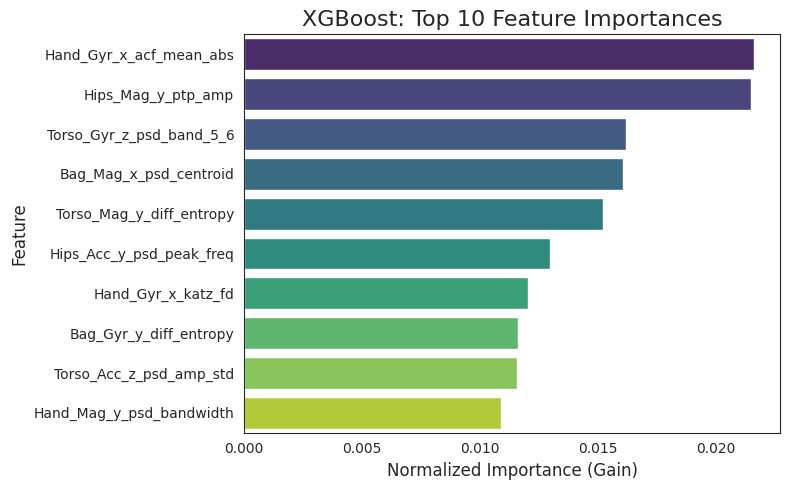

In [3]:
# Cell 1: Imports
import os
import glob
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# Machine Learning Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb

# Plotting Imports
import matplotlib.pyplot as plt
import seaborn as sns

print("import complete")

# === Settings ===
DATA_ROOT    = '/net/tscratch/people/plgdusza/Image Dataset/Baza danych Challange Sussex 2025/features'
glob_pattern = os.path.join(DATA_ROOT, '*', '*.csv')

# === 1. Load + Concatenate All Feature CSVs ===
all_files = glob.glob(glob_pattern)
print(f"Found {len(all_files)} feature files.")  # e.g. 52 now

dfs = []
number_file=0
for fp in tqdm(all_files, desc='Loading feature CSVs', unit='file'):
    dfs.append(pd.read_csv(fp))
    number_file+=1
    print("Read file number", number_file)
df_all = pd.concat(dfs, ignore_index=True)
df_all = df_all.sample(frac=1, random_state=42).reset_index(drop=True)
print("Combined long shape:", df_all.shape)
print("Mode distribution:\n", df_all['mode'].value_counts())

# === 2. Pivot to Wide: one row per (location, window_id) with 13 sensors side by side ===
wide_frames = []
number_folder=0
for loc in df_all['location'].unique():
    df_loc = df_all[df_all['location'] == loc]
    # mode per window
    mode_map = df_loc[['window_id','mode']].drop_duplicates().set_index('window_id')['mode']
    # pivot so each sensor_axis’s features become their own block of columns
    df_p = (
        df_loc
        .drop(columns=['location','mode'])
        .set_index(['window_id','sensor_axis'])
        .unstack('sensor_axis')
    )
    # flatten columns: e.g. ('mean','Acc_x') → 'Bag_Acc_x_mean'
    df_p.columns = [
        f"{loc}_{sensor}_{feat}"
        for feat, sensor in df_p.columns
    ]
    df_p = df_p.reset_index()
    df_p['mode'] = df_p['window_id'].map(mode_map)
    wide_frames.append(df_p)
    number_folder+=1
    print("Combined df folder number", number_folder)
    
    
df_wide = pd.concat(wide_frames, ignore_index=True)
print("Wide shape (rows=windows, cols=13 sensors×features + window_id + mode):", df_wide.shape)
print("Mode distribution:\n", df_wide['mode'].value_counts())

# === 3. Take a 5% Random Sample (for speed) ===
df_sample = df_wide.sample(frac=0.005, random_state=42).reset_index(drop=True)
print("Sampled shape (5%):", df_sample.shape)
print("Mode distribution in sample:\n", df_sample['mode'].value_counts())

# === 4. Prepare X and y ===
X = df_sample.drop(columns=['window_id','mode'])
y = df_sample['mode']

# === 5. Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)
print("Training size:", X_train.shape, "| Testing size:", X_test.shape)

# Plotting style
sns.set_style("white")
cmap_choice = plt.cm.viridis
labels = ["Still","Walk","Run","Bike","Car","Bus","Train","Subway"]

# === 6. XGBoost ===
# XGBoost needs 0–7 labels rather than 1–8
y_train_enc = y_train.astype(int) - 1
y_test_enc  = y_test.astype(int)  - 1

xgb_model = xgb.XGBClassifier(
    booster='gbtree',
    n_estimators=80,
    max_depth=8,
    learning_rate=0.3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
print("\nTraining XGBoost …")
xgb_model.fit(X_train, y_train_enc)

# === 7. XGBoost Evaluation ===
y_pred_xgb_enc = xgb_model.predict(X_test)
print("\n=== XGBoost: Classification Report ===")
print(classification_report(y_test_enc, y_pred_xgb_enc, digits=4))

cm = confusion_matrix(y_test_enc, y_pred_xgb_enc)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

fig, ax = plt.subplots(figsize=(8,6), dpi=100)
sns.heatmap(cm_df, annot=True, fmt="d", cmap=cmap_choice, linewidths=0.5,
            linecolor="gray", square=True, cbar_kws={"shrink":0.8}, ax=ax)
mask = np.ones_like(cm_df, dtype=bool)
np.fill_diagonal(mask, False)
sns.heatmap(cm_df, mask=mask, annot=True, fmt="d", linewidths=0.5,
            linecolor="gray", square=True, cbar=False, ax=ax)
ax.set_title("XGBoost: Confusion Matrix", fontsize=16, pad=12)
ax.set_xlabel("Predicted Label", fontsize=12, labelpad=8)
ax.set_ylabel("True Label", fontsize=12, labelpad=8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

# === 8. XGBoost Feature Importances ===
imp = xgb_model.feature_importances_
feat_names = X_train.columns.tolist()
imp_df = pd.DataFrame({'feature':feat_names, 'importance':imp})\
            .sort_values('importance', ascending=False).reset_index(drop=True)

print("\nTop 10 Features – XGBoost:")
print(imp_df.head(10))

plt.figure(figsize=(8,5), dpi=100)
sns.barplot(data=imp_df.head(10), x='importance', y='feature', palette='viridis')
plt.title("XGBoost: Top 10 Feature Importances", fontsize=16)
plt.xlabel("Normalized Importance (Gain)", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()


Sampled shape (1%): (78429, 3850)
Mode distribution in sample:
 mode
5.0    12612
7.0    12504
6.0    11489
2.0     9832
1.0     9806
8.0     9522
4.0     9228
3.0     3436
Name: count, dtype: int64
Training size: (62743, 3848) | Testing size: (15686, 3848)

Training XGBoost on GPU …


/net/people/plgrid/plgdusza/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:50:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost: Classification Report ===
              precision    recall  f1-score   support

           0     0.8028    0.8929    0.8455      1961
           1     0.9662    0.9583    0.9622      1966
           2     0.9985    0.9854    0.9919       687
           3     0.9743    0.9648    0.9695      1846
           4     0.9340    0.9366    0.9353      2523
           5     0.8810    0.8538    0.8672      2298
           6     0.7605    0.7541    0.7573      2501
           7     0.7395    0.7038    0.7212      1904

    accuracy                         0.8698     15686
   macro avg     0.8821    0.8812    0.8813     15686
weighted avg     0.8702    0.8698    0.8696     15686



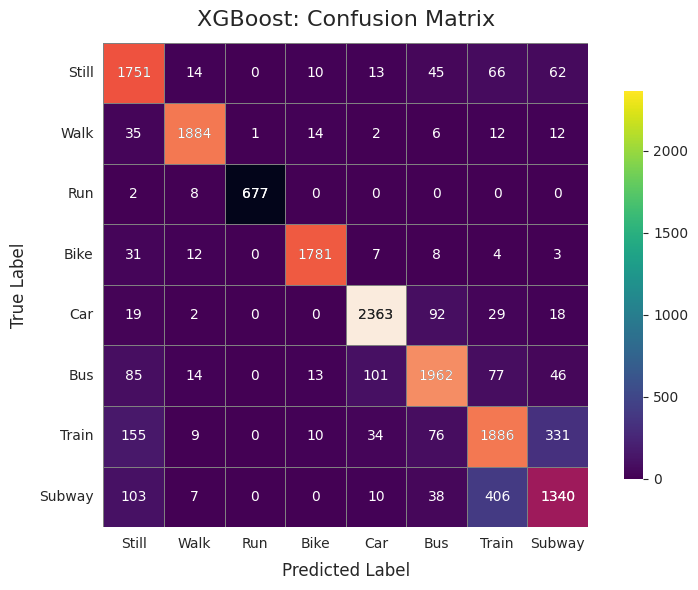


Top 10 Features – XGBoost:
                               feature  importance
0            Torso_Acc_y_psd_peak_freq    0.013656
1       Torso_Acc_z_mean_crossing_rate    0.010971
2          Bag_Acc_x_wavelet_energy_L2    0.010521
3                   Hips_Acc_y_acf_std    0.009904
4            Bag_Mag_x_hjorth_mobility    0.009833
5                  Torso_Acc_y_acf_std    0.009590
6   Bag_Acc_solo_mag_wavelet_energy_L0    0.009053
7  Hips_Acc_solo_mag_wavelet_energy_L3    0.008338
8              Hand_Gyr_z_acf_mean_abs    0.007781
9        Bag_Acc_solo_mag_psd_band_4_5    0.007188


/net/tscratch/people/plgdusza/slurm_jobdir/1467920/tmp.t0039/ipykernel_907352/2775367664.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df.head(10), x='importance', y='feature', palette='viridis')


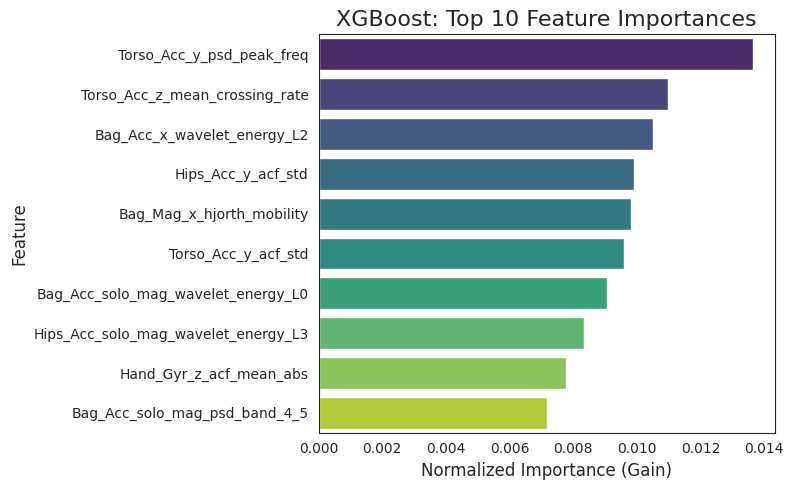

In [9]:

# === 3. Take a 1% Random Sample (for speed) ===
df_sample = df_wide.sample(frac=0.1, random_state=42).reset_index(drop=True)
print("Sampled shape (1%):", df_sample.shape)
print("Mode distribution in sample:\n", df_sample['mode'].value_counts())

# === 4. Prepare X and y ===
X = df_sample.drop(columns=['window_id','mode'])
y = df_sample['mode']

# === 5. Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)
print("Training size:", X_train.shape, "| Testing size:", X_test.shape)

# Plotting style
sns.set_style("white")
cmap_choice = plt.cm.viridis
labels = ["Still","Walk","Run","Bike","Car","Bus","Train","Subway"]

# === 6. XGBoost with GPU ===
# Shift labels from 1–8 to 0–7
y_train_enc = y_train.astype(int) - 1
y_test_enc  = y_test.astype(int)  - 1

xgb_model = xgb.XGBClassifier(
    tree_method='hist',           # CPU histogram or GPU, depending on `device`
    predictor='gpu_predictor',
    device='cuda:0',              # first GPU; omit gpu_id
    n_estimators=80,
    max_depth=8,
    learning_rate=0.3,
    random_state=42,
    n_jobs=-1,
    verbosity=1
)


print("\nTraining XGBoost on GPU …")
xgb_model.fit(X_train, y_train_enc)

# === 7. Evaluation (unchanged) ===
y_pred_xgb_enc = xgb_model.predict(X_test)
print("\n=== XGBoost: Classification Report ===")
print(classification_report(y_test_enc, y_pred_xgb_enc, digits=4))

cm = confusion_matrix(y_test_enc, y_pred_xgb_enc)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

fig, ax = plt.subplots(figsize=(8,6), dpi=100)
sns.heatmap(cm_df, annot=True, fmt="d", cmap=cmap_choice, linewidths=0.5,
            linecolor="gray", square=True, cbar_kws={"shrink":0.8}, ax=ax)
mask = np.ones_like(cm_df, dtype=bool)
np.fill_diagonal(mask, False)
sns.heatmap(cm_df, mask=mask, annot=True, fmt="d", linewidths=0.5,
            linecolor="gray", square=True, cbar=False, ax=ax)
ax.set_title("XGBoost: Confusion Matrix", fontsize=16, pad=12)
ax.set_xlabel("Predicted Label", fontsize=12, labelpad=8)
ax.set_ylabel("True Label", fontsize=12, labelpad=8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

# === 8. Feature Importances (unchanged) ===
imp = xgb_model.feature_importances_
feat_names = X_train.columns.tolist()
imp_df = pd.DataFrame({'feature':feat_names, 'importance':imp})\
            .sort_values('importance', ascending=False).reset_index(drop=True)

print("\nTop 10 Features – XGBoost:") 
print(imp_df.head(10))

plt.figure(figsize=(8,5), dpi=100)
sns.barplot(data=imp_df.head(10), x='importance', y='feature', palette='viridis')
plt.title("XGBoost: Top 10 Feature Importances", fontsize=16)
plt.xlabel("Normalized Importance (Gain)", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()


Training size: (62743, 3848) | Testing size: (15686, 3848)

Training XGBoost on GPU …


/net/people/plgrid/plgdusza/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:53:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost: Classification Report ===
              precision    recall  f1-score   support

           0     0.8045    0.9046    0.8517      1961
           1     0.9696    0.9578    0.9637      1966
           2     0.9985    0.9898    0.9942       687
           3     0.9686    0.9680    0.9683      1846
           4     0.9470    0.9481    0.9475      2523
           5     0.9038    0.8708    0.8870      2298
           6     0.7896    0.7789    0.7842      2501
           7     0.7741    0.7342    0.7536      1904

    accuracy                         0.8838     15686
   macro avg     0.8945    0.8940    0.8938     15686
weighted avg     0.8844    0.8838    0.8836     15686



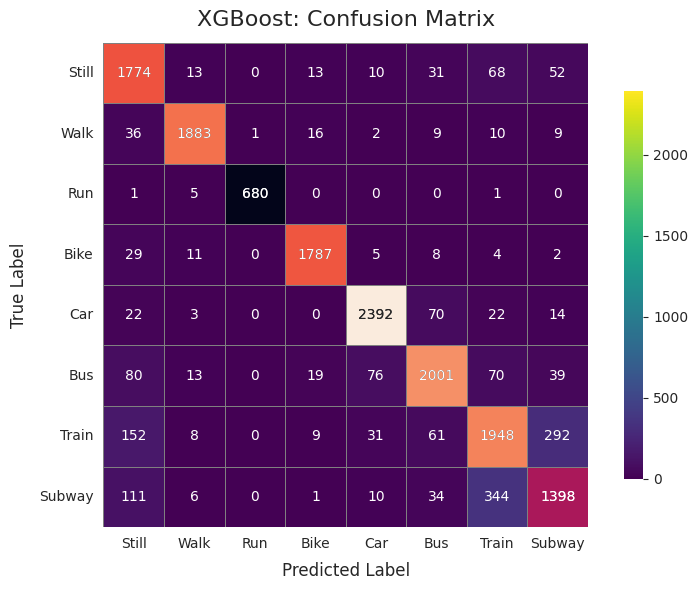


Top 10 Features – XGBoost:
                               feature  importance
0       Torso_Acc_z_mean_crossing_rate    0.018214
1            Torso_Acc_y_psd_peak_freq    0.016839
2             Hand_Gyr_y_acf_prom_freq    0.012779
3               Bag_Gyr_z_diff_entropy    0.012619
4                   Hips_Acc_y_acf_std    0.012485
5                  Torso_Acc_y_acf_std    0.012053
6        Hips_Acc_z_mean_crossing_rate    0.010257
7   Bag_Acc_solo_mag_wavelet_energy_L0    0.009706
8  Hips_Acc_solo_mag_wavelet_energy_L3    0.009523
9        Bag_Acc_solo_mag_psd_band_4_5    0.009100


/net/tscratch/people/plgdusza/slurm_jobdir/1467920/tmp.t0039/ipykernel_907352/2854422082.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df.head(10), x='importance', y='feature', palette='viridis')


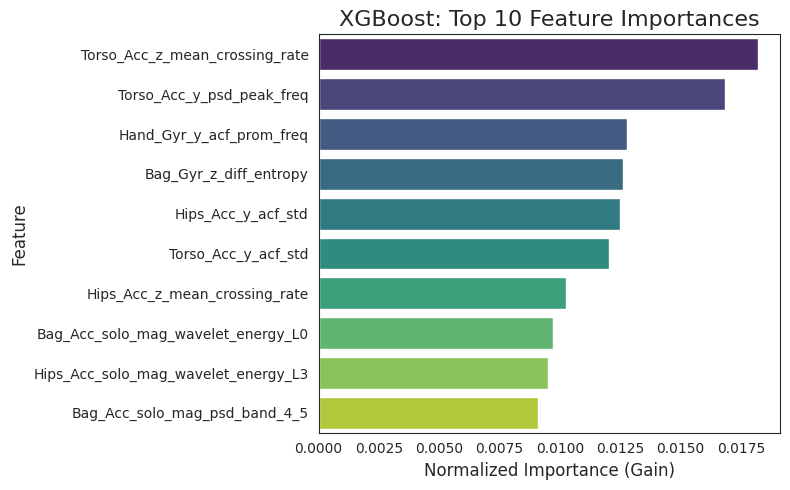

In [14]:
# === 5. Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)
print("Training size:", X_train.shape, "| Testing size:", X_test.shape)

# Plotting style
sns.set_style("white")
cmap_choice = plt.cm.viridis
labels = ["Still","Walk","Run","Bike","Car","Bus","Train","Subway"]

# === 6. XGBoost with GPU ===
# Shift labels from 1–8 to 0–7
y_train_enc = y_train.astype(int) - 1
y_test_enc  = y_test.astype(int)  - 1

xgb_model = xgb.XGBClassifier(
    tree_method='hist',           # CPU histogram or GPU, depending on `device`
    predictor='gpu_predictor',
    device='cuda:0',              # first GPU; omit gpu_id
    n_estimators=180,
    max_depth=8,
    learning_rate=0.4,
    random_state=42,
    n_jobs=-1,
    verbosity=1
)


print("\nTraining XGBoost on GPU …")
xgb_model.fit(X_train, y_train_enc)

# === 7. Evaluation (unchanged) ===
y_pred_xgb_enc = xgb_model.predict(X_test)
print("\n=== XGBoost: Classification Report ===")
print(classification_report(y_test_enc, y_pred_xgb_enc, digits=4))

cm = confusion_matrix(y_test_enc, y_pred_xgb_enc)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

fig, ax = plt.subplots(figsize=(8,6), dpi=100)
sns.heatmap(cm_df, annot=True, fmt="d", cmap=cmap_choice, linewidths=0.5,
            linecolor="gray", square=True, cbar_kws={"shrink":0.8}, ax=ax)
mask = np.ones_like(cm_df, dtype=bool)
np.fill_diagonal(mask, False)
sns.heatmap(cm_df, mask=mask, annot=True, fmt="d", linewidths=0.5,
            linecolor="gray", square=True, cbar=False, ax=ax)
ax.set_title("XGBoost: Confusion Matrix", fontsize=16, pad=12)
ax.set_xlabel("Predicted Label", fontsize=12, labelpad=8)
ax.set_ylabel("True Label", fontsize=12, labelpad=8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

# === 8. Feature Importances (unchanged) ===
imp = xgb_model.feature_importances_
feat_names = X_train.columns.tolist()
imp_df = pd.DataFrame({'feature':feat_names, 'importance':imp})\
            .sort_values('importance', ascending=False).reset_index(drop=True)

print("\nTop 10 Features – XGBoost:") 
print(imp_df.head(10))

plt.figure(figsize=(8,5), dpi=100)
sns.barplot(data=imp_df.head(10), x='importance', y='feature', palette='viridis')
plt.title("XGBoost: Top 10 Feature Importances", fontsize=16)
plt.xlabel("Normalized Importance (Gain)", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()


Sampled shape (20%): (156858, 3850)
Mode distribution in sample:
 mode
5.0    25284
7.0    25052
6.0    22702
2.0    19737
1.0    19539
8.0    18987
4.0    18820
3.0     6737
Name: count, dtype: int64
Train size: (125486, 3848) | Test size: (31372, 3848)

=== Run 1/1 — Params: {'subsample': 0.9, 'reg_lambda': 3, 'reg_alpha': 0.01, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.3, 'gamma': 0.3, 'colsample_bytree': 0.5} ===
Macro-average F1 Score: 0.9118

Classification Report:
              precision    recall  f1-score   support

       Still     0.8363    0.9138    0.8733      3908
        Walk     0.9661    0.9592    0.9626      3947
         Run     0.9970    0.9889    0.9929      1347
        Bike     0.9746    0.9676    0.9711      3764
         Car     0.9592    0.9539    0.9566      5057
         Bus     0.9186    0.9027    0.9106      4541
       Train     0.8357    0.8180    0.8267      5011
      Subway     0.8096    0.7919    0.8007      3797


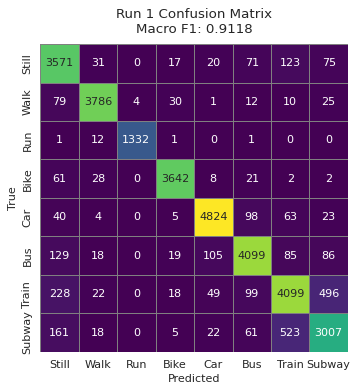


Best hyperparameters (by macro F1):
{'subsample': 0.9, 'reg_lambda': 3, 'reg_alpha': 0.01, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.3, 'gamma': 0.3, 'colsample_bytree': 0.5}
Best test-set macro F1: 0.9118
Saved best model to: best_xgb_model_by_macro_f1.joblib


In [18]:
from tqdm.auto import tqdm
import xgboost as xgb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# === 0. How many random configs to try? ===
n_iter_search = 10   # ← set this to however many runs you want

# === 1. Sample your data (2% for speed) ===
df_sample = df_wide.sample(frac=0.2, random_state=42).reset_index(drop=True)
print("Sampled shape (20%):", df_sample.shape)
print("Mode distribution in sample:\n", df_sample['mode'].value_counts())

# === 2. Prepare features & labels ===
X = df_sample.drop(columns=['window_id','mode'])
y = df_sample['mode']

# === 3. Train/Test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("Train size:", X_train.shape, "| Test size:", X_test.shape)

# === 4. Encode y for XGBoost (0–7) ===
y_train_enc = y_train.astype(int) - 1
y_test_enc  = y_test.astype(int)  - 1

# plotting defaults
sns.set_style("white")
cmap_choice = plt.cm.viridis
labels = ["Still","Walk","Run","Bike","Car","Bus","Train","Subway"]

# === 5. Define hyperparameter search space ===
param_dist = {
    "n_estimators":     [50, 100, 150, 200, 300],           # number of boosting rounds 
    "max_depth":        [7, 9, 12, 14],                  # tree complexity
    "learning_rate":    [0.01, 0.05, 0.1, 0.2, 0.3],       # shrinkage factor
    "subsample":        [0.6, 0.7, 0.8, 0.9, 1.0],          # row sampling
    "colsample_bytree": [0.5, 0.7, 0.8, 1.0],               # feature sampling
    "gamma":            [0, 0.1, 0.2, 0.3, 0.5],            # min loss reduction
    "min_child_weight": [1, 3, 5, 7],                      # minimum leaf instance
    "reg_alpha":        [0, 0.01, 0.1, 1],                  # L1 regularization
    "reg_lambda":       [1, 1.5, 2, 3]                      # L2 regularization
}

# === 6. Sample random hyperparameter sets ===
param_list = list(ParameterSampler(param_dist, n_iter_search, random_state=42))

# Prepare to track the best
best_f1    = -1.0
best_model = None
best_params= None

for idx, params in enumerate(param_list, start=1):
    print(f"\n=== Run {idx}/{n_iter_search} — Params: {params} ===")
    model = xgb.XGBClassifier(
        tree_method='hist',
        predictor='gpu_predictor',
        device='cuda:0',
        random_state=42,
        verbosity=0,
        n_jobs=-1,
        **params
    )
    model.fit(X_train, y_train_enc)
    y_pred = model.predict(X_test)
    
    # compute macro (un-weighted) F1
    f1 = f1_score(y_test_enc, y_pred, average='macro')
    print(f"Macro-average F1 Score: {f1:.4f}")
    
    # classification report
    print("\nClassification Report:")
    print(classification_report(y_test_enc, y_pred, target_names=labels, digits=4))
    
    # plot confusion matrix only
    cm = confusion_matrix(y_test_enc, y_pred)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(6,5), dpi=80)
    sns.heatmap(cm_df, annot=True, fmt='d',
                cmap=cmap_choice, linewidths=0.5,
                linecolor='gray', square=True, cbar=False)
    plt.title(f"Run {idx} Confusion Matrix\nMacro F1: {f1:.4f}", pad=10)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    # update best model by macro F1
    if f1 > best_f1:
        best_f1    = f1
        best_model = model
        best_params= params

# After loop
print("\n" + "="*60)
print("Best hyperparameters (by macro F1):")
print(best_params)
print(f"Best test-set macro F1: {best_f1:.4f}")
print("="*60)

# Save the best model to disk with joblib
output_path = "best_xgb_model_by_macro_f1.joblib"
joblib.dump(best_model, output_path)
print(f"Saved best model to: {output_path}")


In [4]:
pip install numba

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 80.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 83.3 MB/s eta 0:00:00:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.0
    Uninstalling numpy-1.23.0:
      Successfully uninstalled numpy-1.23.0
  You can safely remove it manually.
  You can safely remove it manually.

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install --upgrade "numpy==1.24.3"

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 66.1 MB/s eta 0:00:00ta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.0
    Uninstalling numpy-1.24.0:
      Successfully uninstalled numpy-1.24.0

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.



=== Run 1/10 — Params: {'subsample': 0.9, 'reg_lambda': 3, 'reg_alpha': 0.01, 'n_estimators': 50, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.7} ===
Macro-average F1 Score: 0.8563

Classification Report:
              precision    recall  f1-score   support

       Still     0.7712    0.8721    0.8185      3908
        Walk     0.9543    0.9521    0.9532      3947
         Run     0.9977    0.9852    0.9914      1347
        Bike     0.9626    0.9567    0.9596      3764
         Car     0.8987    0.8875    0.8930      5057
         Bus     0.8222    0.8267    0.8244      4541
       Train     0.7333    0.7434    0.7383      5011
      Subway     0.7222    0.6284    0.6720      3797

    accuracy                         0.8430     31372
   macro avg     0.8578    0.8565    0.8563     31372
weighted avg     0.8429    0.8430    0.8421     31372



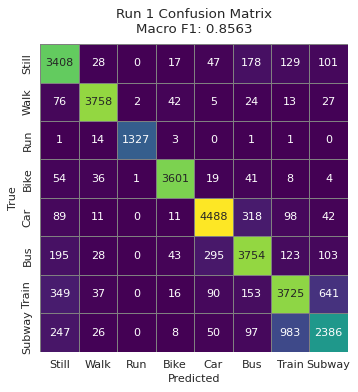


=== Run 2/10 — Params: {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 1, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.7} ===
Macro-average F1 Score: 0.9060

Classification Report:
              precision    recall  f1-score   support

       Still     0.8229    0.9158    0.8669      3908
        Walk     0.9651    0.9602    0.9627      3947
         Run     0.9970    0.9881    0.9925      1347
        Bike     0.9743    0.9652    0.9697      3764
         Car     0.9535    0.9478    0.9506      5057
         Bus     0.9052    0.8939    0.8995      4541
       Train     0.8334    0.8096    0.8213      5011
      Subway     0.8004    0.7701    0.7850      3797

    accuracy                         0.8978     31372
   macro avg     0.9065    0.9063    0.9060     31372
weighted avg     0.8984    0.8978    0.8977     31372



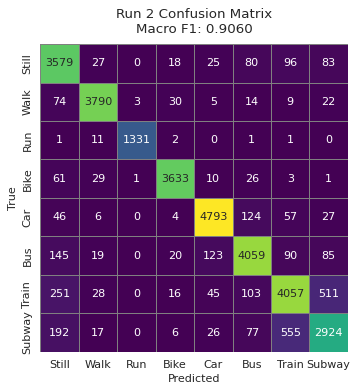


=== Run 3/10 — Params: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 0.1, 'colsample_bytree': 0.7} ===
Macro-average F1 Score: 0.9011

Classification Report:
              precision    recall  f1-score   support

       Still     0.8250    0.9058    0.8635      3908
        Walk     0.9659    0.9554    0.9606      3947
         Run     0.9963    0.9881    0.9922      1347
        Bike     0.9740    0.9665    0.9703      3764
         Car     0.9542    0.9444    0.9493      5057
         Bus     0.9013    0.8890    0.8951      4541
       Train     0.8107    0.8034    0.8071      5011
      Subway     0.7856    0.7564    0.7707      3797

    accuracy                         0.8922     31372
   macro avg     0.9016    0.9011    0.9011     31372
weighted avg     0.8928    0.8922    0.8922     31372



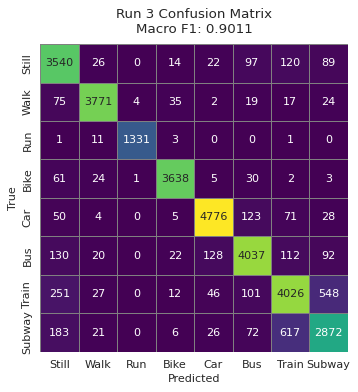


=== Run 4/10 — Params: {'subsample': 0.9, 'reg_lambda': 3, 'reg_alpha': 1, 'n_estimators': 50, 'min_child_weight': 7, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 1.0} ===
Macro-average F1 Score: 0.7988

Classification Report:
              precision    recall  f1-score   support

       Still     0.7403    0.7958    0.7670      3908
        Walk     0.9124    0.9291    0.9207      3947
         Run     0.9962    0.9755    0.9857      1347
        Bike     0.9259    0.9129    0.9193      3764
         Car     0.8106    0.8280    0.8192      5057
         Bus     0.7516    0.7065    0.7283      4541
       Train     0.6459    0.6917    0.6680      5011
      Subway     0.6238    0.5460    0.5823      3797

    accuracy                         0.7797     31372
   macro avg     0.8009    0.7982    0.7988     31372
weighted avg     0.7790    0.7797    0.7787     31372



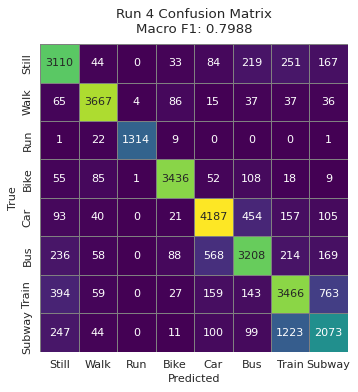


=== Run 5/10 — Params: {'subsample': 0.9, 'reg_lambda': 3, 'reg_alpha': 0.1, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.8} ===
Macro-average F1 Score: 0.9033

Classification Report:
              precision    recall  f1-score   support

       Still     0.8175    0.9179    0.8648      3908
        Walk     0.9645    0.9577    0.9611      3947
         Run     0.9977    0.9874    0.9925      1347
        Bike     0.9717    0.9671    0.9694      3764
         Car     0.9516    0.9454    0.9485      5057
         Bus     0.9042    0.8879    0.8960      4541
       Train     0.8283    0.8036    0.8158      5011
      Subway     0.7948    0.7622    0.7782      3797

    accuracy                         0.8948     31372
   macro avg     0.9038    0.9036    0.9033     31372
weighted avg     0.8954    0.8948    0.8946     31372



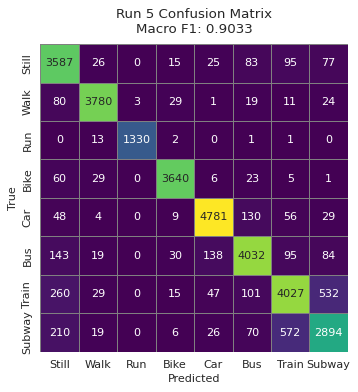


=== Run 6/10 — Params: {'subsample': 1.0, 'reg_lambda': 3, 'reg_alpha': 0.01, 'n_estimators': 150, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.7} ===
Macro-average F1 Score: 0.8643

Classification Report:
              precision    recall  f1-score   support

       Still     0.7749    0.8754    0.8221      3908
        Walk     0.9503    0.9549    0.9526      3947
         Run     0.9970    0.9866    0.9918      1347
        Bike     0.9590    0.9567    0.9578      3764
         Car     0.9012    0.9041    0.9027      5057
         Bus     0.8490    0.8274    0.8381      4541
       Train     0.7648    0.7444    0.7544      5011
      Subway     0.7214    0.6703    0.6949      3797

    accuracy                         0.8518     31372
   macro avg     0.8647    0.8650    0.8643     31372
weighted avg     0.8516    0.8518    0.8512     31372



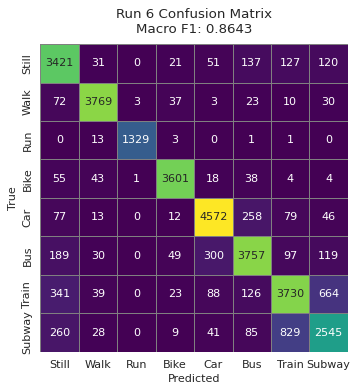


=== Run 7/10 — Params: {'subsample': 0.9, 'reg_lambda': 1.5, 'reg_alpha': 0.01, 'n_estimators': 150, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.7} ===
Macro-average F1 Score: 0.9062

Classification Report:
              precision    recall  f1-score   support

       Still     0.8198    0.9153    0.8649      3908
        Walk     0.9675    0.9569    0.9622      3947
         Run     0.9963    0.9881    0.9922      1347
        Bike     0.9743    0.9668    0.9705      3764
         Car     0.9585    0.9512    0.9548      5057
         Bus     0.9111    0.8912    0.9010      4541
       Train     0.8303    0.8074    0.8187      5011
      Subway     0.7952    0.7751    0.7850      3797

    accuracy                         0.8979     31372
   macro avg     0.9066    0.9065    0.9062     31372
weighted avg     0.8988    0.8979    0.8980     31372



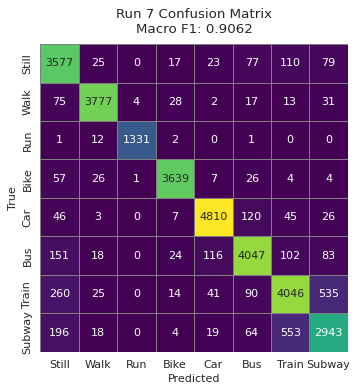


=== Run 8/10 — Params: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 150, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 0.8} ===
Macro-average F1 Score: 0.9047

Classification Report:
              precision    recall  f1-score   support

       Still     0.8263    0.9120    0.8670      3908
        Walk     0.9684    0.9549    0.9616      3947
         Run     0.9970    0.9896    0.9933      1347
        Bike     0.9725    0.9668    0.9696      3764
         Car     0.9560    0.9488    0.9524      5057
         Bus     0.9081    0.8943    0.9011      4541
       Train     0.8192    0.8066    0.8129      5011
      Subway     0.7939    0.7659    0.7796      3797

    accuracy                         0.8961     31372
   macro avg     0.9052    0.9049    0.9047     31372
weighted avg     0.8967    0.8961    0.8961     31372



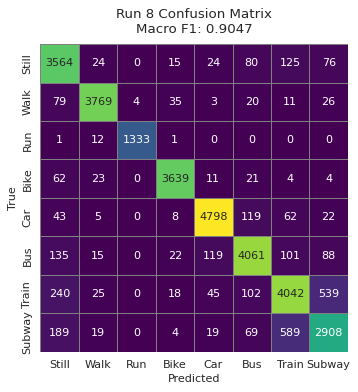


=== Run 9/10 — Params: {'subsample': 0.7, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 150, 'min_child_weight': 7, 'max_depth': 7, 'learning_rate': 0.3, 'gamma': 0.2, 'colsample_bytree': 0.5} ===
Macro-average F1 Score: 0.9004

Classification Report:
              precision    recall  f1-score   support

       Still     0.8223    0.9092    0.8635      3908
        Walk     0.9620    0.9557    0.9588      3947
         Run     0.9963    0.9896    0.9929      1347
        Bike     0.9737    0.9641    0.9689      3764
         Car     0.9490    0.9488    0.9489      5057
         Bus     0.9099    0.8899    0.8998      4541
       Train     0.8131    0.7875    0.8001      5011
      Subway     0.7785    0.7617    0.7700      3797

    accuracy                         0.8914     31372
   macro avg     0.9006    0.9008    0.9004     31372
weighted avg     0.8918    0.8914    0.8913     31372



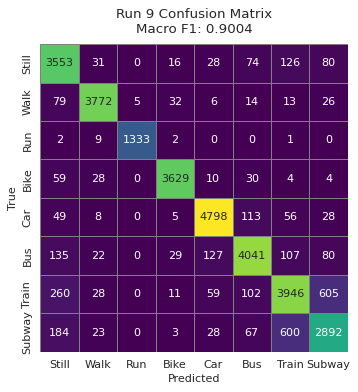


=== Run 10/10 — Params: {'subsample': 0.8, 'reg_lambda': 3, 'reg_alpha': 0.1, 'n_estimators': 50, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.7} ===
Macro-average F1 Score: 0.8445

Classification Report:
              precision    recall  f1-score   support

       Still     0.7606    0.8477    0.8018      3908
        Walk     0.9434    0.9460    0.9447      3947
         Run     0.9985    0.9852    0.9918      1347
        Bike     0.9452    0.9527    0.9489      3764
         Car     0.8704    0.8738    0.8721      5057
         Bus     0.8035    0.7926    0.7980      4541
       Train     0.7312    0.7238    0.7275      5011
      Subway     0.7081    0.6376    0.6710      3797

    accuracy                         0.8296     31372
   macro avg     0.8451    0.8449    0.8445     31372
weighted avg     0.8288    0.8296    0.8287     31372



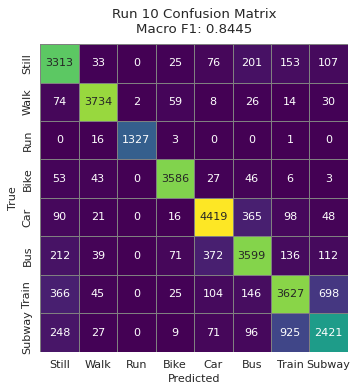


Best hyperparameters (by macro F1):
{'subsample': 0.9, 'reg_lambda': 1.5, 'reg_alpha': 0.01, 'n_estimators': 150, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.7}
Best test-set macro F1: 0.9062


In [10]:
import gc
from numba import cuda
from tqdm.auto import tqdm
import xgboost as xgb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# === 0. How many random configs to try? ===
n_iter_search = 10   # ← set this to however many runs you want
'''
# === 1. Sample your data (20% for speed) ===
df_sample = df_wide.sample(frac=0.2, random_state=42).reset_index(drop=True)
print("Sampled shape (20%):", df_sample.shape)
print("Mode distribution in sample:\n", df_sample['mode'].value_counts())

# === 2. Prepare features & labels ===
X = df_sample.drop(columns=['window_id','mode'])
y = df_sample['mode']

# === 3. Train/Test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("Train size:", X_train.shape, "| Test size:", X_test.shape)

# === 4. Encode y for XGBoost (0–7) ===
y_train_enc = y_train.astype(int) - 1
y_test_enc  = y_test.astype(int)  - 1
'''
# plotting defaults
sns.set_style("white")
cmap_choice = plt.cm.viridis
labels = ["Still","Walk","Run","Bike","Car","Bus","Train","Subway"]

# === 5. Define hyperparameter search space ===
param_dist = {
    "n_estimators":     [150, 200, 250],           # number of boosting rounds 
    "max_depth":        [7, 9, 10],                  # tree complexity
    "learning_rate":    [0.1, 0.2, 0.3, 0.4],       # shrinkage factor
    "subsample":        [0.6, 0.7, 0.8, 0.9, 1.0],          # row sampling
    "colsample_bytree": [0.5, 0.7, 0.8, 1.0],               # feature sampling
    "gamma":            [0, 0.1, 0.2, 0.3, 0.5],            # min loss reduction
    "min_child_weight": [1, 3, 5, 7],                      # minimum leaf instance
    "reg_alpha":        [0, 0.01, 0.1, 1],                  # L1 regularization
    "reg_lambda":       [1, 1.5, 2, 3]                      # L2 regularization
}

# === 6. Sample random hyperparameter sets ===
param_list = list(ParameterSampler(param_dist, n_iter_search, random_state=42))

# Prepare to track the best
best_f1    = -1.0
best_model = None
best_params= None

for idx, params in enumerate(param_list, start=1):
    print(f"\n=== Run {idx}/{n_iter_search} — Params: {params} ===")
    model = xgb.XGBClassifier(
        tree_method='hist',
        predictor='gpu_predictor',
        device='cuda:0',
        random_state=42,
        verbosity=0,
        n_jobs=-1,
        **params
    )
    model.fit(X_train, y_train_enc)
    y_pred = model.predict(X_test)
    
    # compute macro (un-weighted) F1
    f1 = f1_score(y_test_enc, y_pred, average='macro')
    print(f"Macro-average F1 Score: {f1:.4f}")
    
    # classification report
    print("\nClassification Report:")
    print(classification_report(y_test_enc, y_pred, target_names=labels, digits=4))
    
    # plot confusion matrix only
    cm = confusion_matrix(y_test_enc, y_pred)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(6,5), dpi=80)
    sns.heatmap(cm_df, annot=True, fmt='d',
                cmap=cmap_choice, linewidths=0.5,
                linecolor='gray', square=True, cbar=False)
    plt.title(f"Run {idx} Confusion Matrix\nMacro F1: {f1:.4f}", pad=10)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    # update best model by macro F1
    if f1 > best_f1:
        best_f1, best_params = f1, params

# After loop
print("\n" + "="*60)
print("Best hyperparameters (by macro F1):")
print(best_params)
print(f"Best test-set macro F1: {best_f1:.4f}")
print("="*60)



=== Run 1/30 — Params: {'subsample': 0.9, 'reg_lambda': 3, 'reg_alpha': 0.01, 'n_estimators': 150, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 0.8} ===
Macro-average F1 Score: 0.9073

Classification Report:
              precision    recall  f1-score   support

       Still     0.8276    0.9186    0.8707      3908
        Walk     0.9662    0.9564    0.9613      3947
         Run     0.9970    0.9881    0.9925      1347
        Bike     0.9774    0.9668    0.9721      3764
         Car     0.9607    0.9512    0.9559      5057
         Bus     0.9108    0.8950    0.9028      4541
       Train     0.8288    0.8084    0.8185      5011
      Subway     0.7936    0.7759    0.7847      3797

    accuracy                         0.8991     31372
   macro avg     0.9078    0.9075    0.9073     31372
weighted avg     0.8999    0.8991    0.8991     31372



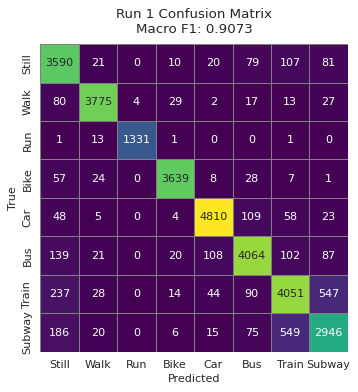


=== Run 2/30 — Params: {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 1, 'n_estimators': 250, 'min_child_weight': 7, 'max_depth': 10, 'learning_rate': 0.3, 'gamma': 0.2, 'colsample_bytree': 0.8} ===
Macro-average F1 Score: 0.9113

Classification Report:
              precision    recall  f1-score   support

       Still     0.8338    0.9181    0.8739      3908
        Walk     0.9658    0.9582    0.9620      3947
         Run     0.9955    0.9881    0.9918      1347
        Bike     0.9730    0.9676    0.9703      3764
         Car     0.9601    0.9516    0.9558      5057
         Bus     0.9147    0.9002    0.9074      4541
       Train     0.8402    0.8182    0.8290      5011
      Subway     0.8095    0.7914    0.8004      3797

    accuracy                         0.9036     31372
   macro avg     0.9116    0.9117    0.9113     31372
weighted avg     0.9042    0.9036    0.9036     31372



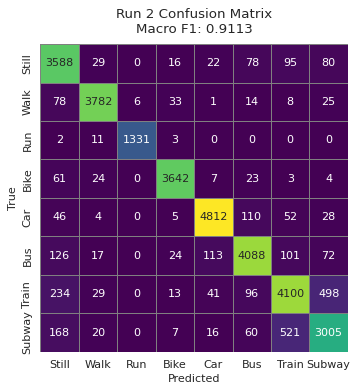


=== Run 3/30 — Params: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 250, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.8} ===
Macro-average F1 Score: 0.9114

Classification Report:
              precision    recall  f1-score   support

       Still     0.8291    0.9202    0.8723      3908
        Walk     0.9670    0.9587    0.9628      3947
         Run     0.9978    0.9881    0.9929      1347
        Bike     0.9751    0.9687    0.9719      3764
         Car     0.9636    0.9529    0.9582      5057
         Bus     0.9189    0.9027    0.9107      4541
       Train     0.8381    0.8148    0.8263      5011
      Subway     0.8051    0.7877    0.7963      3797

    accuracy                         0.9036     31372
   macro avg     0.9118    0.9117    0.9114     31372
weighted avg     0.9044    0.9036    0.9037     31372



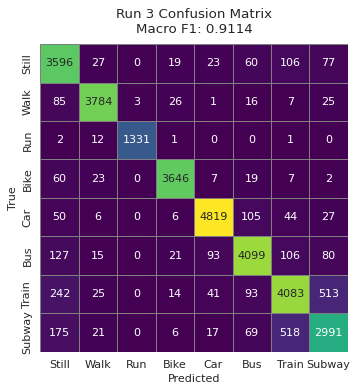


=== Run 4/30 — Params: {'subsample': 1.0, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 150, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.7} ===
Macro-average F1 Score: 0.8878

Classification Report:
              precision    recall  f1-score   support

       Still     0.7983    0.8994    0.8459      3908
        Walk     0.9574    0.9574    0.9574      3947
         Run     0.9963    0.9874    0.9918      1347
        Bike     0.9685    0.9633    0.9659      3764
         Car     0.9323    0.9343    0.9333      5057
         Bus     0.8842    0.8677    0.8758      4541
       Train     0.8054    0.7705    0.7876      5011
      Subway     0.7625    0.7279    0.7448      3797

    accuracy                         0.8779     31372
   macro avg     0.8881    0.8885    0.8878     31372
weighted avg     0.8781    0.8779    0.8775     31372



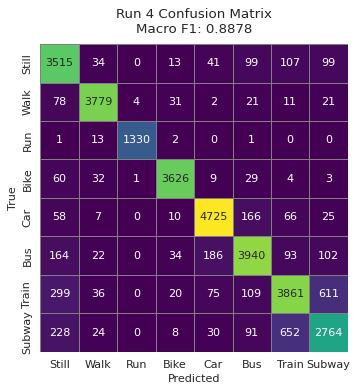


=== Run 5/30 — Params: {'subsample': 1.0, 'reg_lambda': 3, 'reg_alpha': 0.01, 'n_estimators': 200, 'min_child_weight': 7, 'max_depth': 9, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.8} ===
Macro-average F1 Score: 0.9087

Classification Report:
              precision    recall  f1-score   support

       Still     0.8234    0.9184    0.8683      3908
        Walk     0.9665    0.9590    0.9627      3947
         Run     0.9955    0.9881    0.9918      1347
        Bike     0.9741    0.9681    0.9711      3764
         Car     0.9572    0.9516    0.9544      5057
         Bus     0.9135    0.8972    0.9052      4541
       Train     0.8374    0.8100    0.8235      5011
      Subway     0.8046    0.7809    0.7926      3797

    accuracy                         0.9008     31372
   macro avg     0.9090    0.9091    0.9087     31372
weighted avg     0.9014    0.9008    0.9007     31372



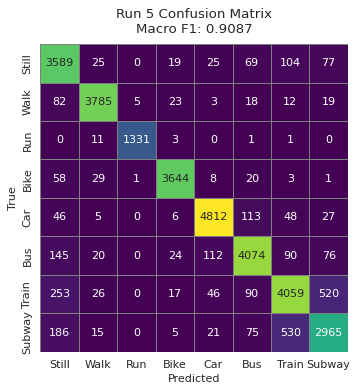


=== Run 6/30 — Params: {'subsample': 0.9, 'reg_lambda': 1.5, 'reg_alpha': 0.01, 'n_estimators': 200, 'min_child_weight': 7, 'max_depth': 7, 'learning_rate': 0.3, 'gamma': 0.5, 'colsample_bytree': 0.7} ===
Macro-average F1 Score: 0.9086

Classification Report:
              precision    recall  f1-score   support

       Still     0.8258    0.9145    0.8679      3908
        Walk     0.9670    0.9577    0.9623      3947
         Run     0.9963    0.9896    0.9929      1347
        Bike     0.9761    0.9676    0.9718      3764
         Car     0.9584    0.9525    0.9555      5057
         Bus     0.9173    0.8961    0.9065      4541
       Train     0.8323    0.8162    0.8242      5011
      Subway     0.7992    0.7767    0.7878      3797

    accuracy                         0.9006     31372
   macro avg     0.9090    0.9089    0.9086     31372
weighted avg     0.9014    0.9006    0.9006     31372



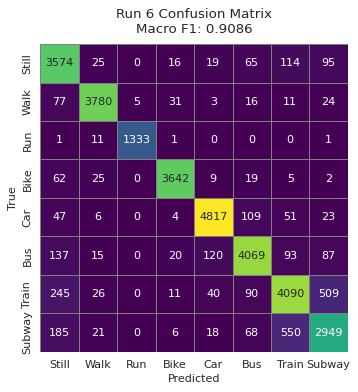


=== Run 7/30 — Params: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 150, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 1.0} ===
Macro-average F1 Score: 0.8875

Classification Report:
              precision    recall  f1-score   support

       Still     0.8011    0.8999    0.8477      3908
        Walk     0.9586    0.9562    0.9574      3947
         Run     0.9955    0.9881    0.9918      1347
        Bike     0.9655    0.9601    0.9628      3764
         Car     0.9338    0.9351    0.9345      5057
         Bus     0.8855    0.8699    0.8776      4541
       Train     0.8021    0.7699    0.7857      5011
      Subway     0.7598    0.7264    0.7427      3797

    accuracy                         0.8776     31372
   macro avg     0.8877    0.8882    0.8875     31372
weighted avg     0.8778    0.8776    0.8772     31372



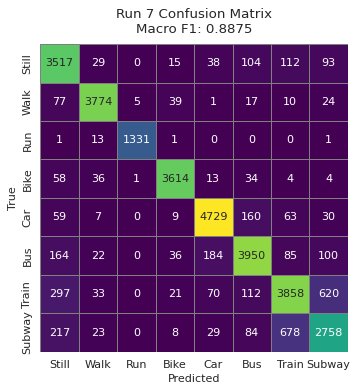


=== Run 8/30 — Params: {'subsample': 0.7, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 250, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.4, 'gamma': 0.5, 'colsample_bytree': 0.5} ===
Macro-average F1 Score: 0.9051

Classification Report:
              precision    recall  f1-score   support

       Still     0.8273    0.9110    0.8671      3908
        Walk     0.9626    0.9587    0.9606      3947
         Run     0.9970    0.9881    0.9925      1347
        Bike     0.9742    0.9644    0.9693      3764
         Car     0.9534    0.9512    0.9523      5057
         Bus     0.9125    0.8912    0.9017      4541
       Train     0.8259    0.8046    0.8151      5011
      Subway     0.7908    0.7738    0.7822      3797

    accuracy                         0.8967     31372
   macro avg     0.9055    0.9054    0.9051     31372
weighted avg     0.8973    0.8967    0.8967     31372



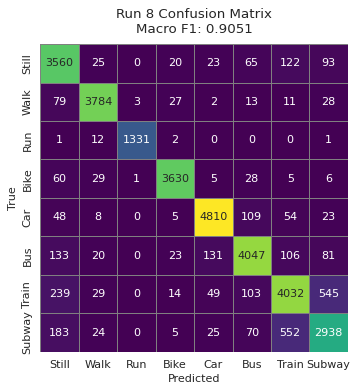


=== Run 9/30 — Params: {'subsample': 0.8, 'reg_lambda': 3, 'reg_alpha': 0.1, 'n_estimators': 150, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.4, 'gamma': 0.1, 'colsample_bytree': 0.8} ===
Macro-average F1 Score: 0.9073

Classification Report:
              precision    recall  f1-score   support

       Still     0.8303    0.9127    0.8696      3908
        Walk     0.9640    0.9574    0.9607      3947
         Run     0.9978    0.9881    0.9929      1347
        Bike     0.9702    0.9673    0.9687      3764
         Car     0.9597    0.9514    0.9555      5057
         Bus     0.9144    0.9007    0.9075      4541
       Train     0.8297    0.8098    0.8196      5011
      Subway     0.7947    0.7727    0.7835      3797

    accuracy                         0.8992     31372
   macro avg     0.9076    0.9075    0.9073     31372
weighted avg     0.8997    0.8992    0.8992     31372



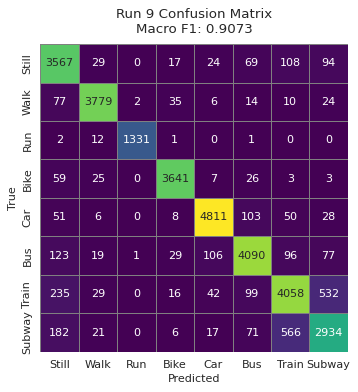


=== Run 10/30 — Params: {'subsample': 0.9, 'reg_lambda': 3, 'reg_alpha': 0, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.3, 'gamma': 0.3, 'colsample_bytree': 1.0} ===
Macro-average F1 Score: 0.9083

Classification Report:
              precision    recall  f1-score   support

       Still     0.8262    0.9199    0.8706      3908
        Walk     0.9690    0.9592    0.9641      3947
         Run     0.9985    0.9866    0.9925      1347
        Bike     0.9753    0.9663    0.9708      3764
         Car     0.9604    0.9494    0.9549      5057
         Bus     0.9139    0.8956    0.9047      4541
       Train     0.8288    0.8126    0.8206      5011
      Subway     0.7993    0.7772    0.7881      3797

    accuracy                         0.9001     31372
   macro avg     0.9089    0.9084    0.9083     31372
weighted avg     0.9010    0.9001    0.9002     31372



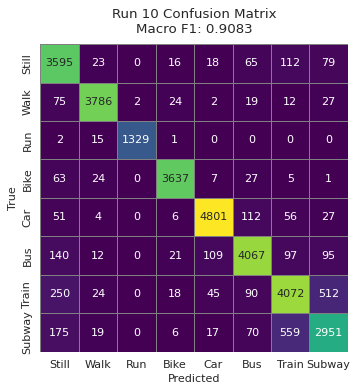


=== Run 11/30 — Params: {'subsample': 0.7, 'reg_lambda': 1.5, 'reg_alpha': 0.01, 'n_estimators': 150, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 0.5, 'colsample_bytree': 0.8} ===
Macro-average F1 Score: 0.9072

Classification Report:
              precision    recall  f1-score   support

       Still     0.8281    0.9112    0.8677      3908
        Walk     0.9648    0.9592    0.9620      3947
         Run     0.9970    0.9889    0.9929      1347
        Bike     0.9725    0.9679    0.9702      3764
         Car     0.9570    0.9516    0.9543      5057
         Bus     0.9169    0.8939    0.9052      4541
       Train     0.8247    0.8104    0.8175      5011
      Subway     0.7993    0.7761    0.7875      3797

    accuracy                         0.8989     31372
   macro avg     0.9076    0.9074    0.9072     31372
weighted avg     0.8995    0.8989    0.8989     31372



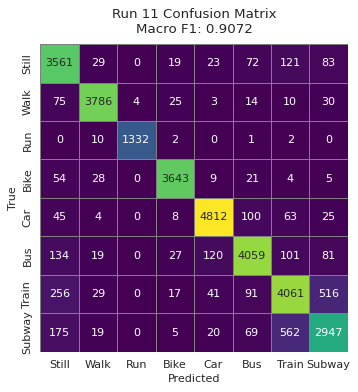


=== Run 12/30 — Params: {'subsample': 0.9, 'reg_lambda': 3, 'reg_alpha': 0.1, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 0.2, 'colsample_bytree': 0.7} ===
Macro-average F1 Score: 0.9112

Classification Report:
              precision    recall  f1-score   support

       Still     0.8332    0.9153    0.8723      3908
        Walk     0.9665    0.9582    0.9623      3947
         Run     0.9963    0.9889    0.9925      1347
        Bike     0.9723    0.9684    0.9703      3764
         Car     0.9617    0.9537    0.9577      5057
         Bus     0.9118    0.8969    0.9043      4541
       Train     0.8383    0.8212    0.8296      5011
      Subway     0.8119    0.7888    0.8002      3797

    accuracy                         0.9034     31372
   macro avg     0.9115    0.9114    0.9112     31372
weighted avg     0.9040    0.9034    0.9034     31372



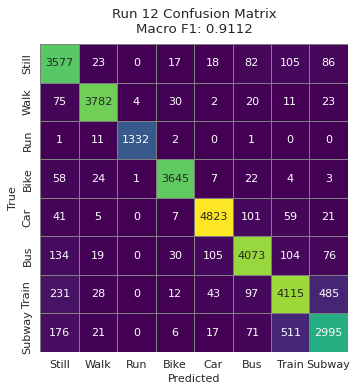


=== Run 13/30 — Params: {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 250, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.4, 'gamma': 0.5, 'colsample_bytree': 0.7} ===
Macro-average F1 Score: 0.9072

Classification Report:
              precision    recall  f1-score   support

       Still     0.8325    0.9094    0.8693      3908
        Walk     0.9623    0.9567    0.9595      3947
         Run     0.9970    0.9881    0.9925      1347
        Bike     0.9714    0.9641    0.9677      3764
         Car     0.9567    0.9523    0.9545      5057
         Bus     0.9146    0.8917    0.9030      4541
       Train     0.8334    0.8118    0.8225      5011
      Subway     0.7918    0.7854    0.7886      3797

    accuracy                         0.8991     31372
   macro avg     0.9075    0.9074    0.9072     31372
weighted avg     0.8997    0.8991    0.8991     31372



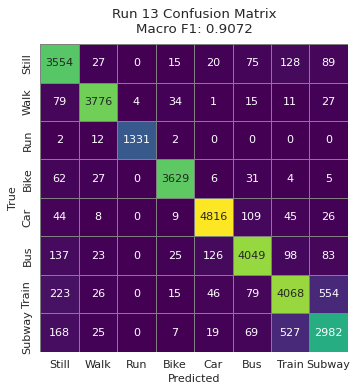


=== Run 14/30 — Params: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.4, 'gamma': 0, 'colsample_bytree': 0.8} ===
Macro-average F1 Score: 0.9114

Classification Report:
              precision    recall  f1-score   support

       Still     0.8357    0.9199    0.8758      3908
        Walk     0.9668    0.9602    0.9635      3947
         Run     0.9970    0.9874    0.9922      1347
        Bike     0.9777    0.9668    0.9722      3764
         Car     0.9612    0.9553    0.9582      5057
         Bus     0.9166    0.9022    0.9093      4541
       Train     0.8370    0.8148    0.8258      5011
      Subway     0.8027    0.7864    0.7945      3797

    accuracy                         0.9037     31372
   macro avg     0.9118    0.9116    0.9114     31372
weighted avg     0.9043    0.9037    0.9037     31372



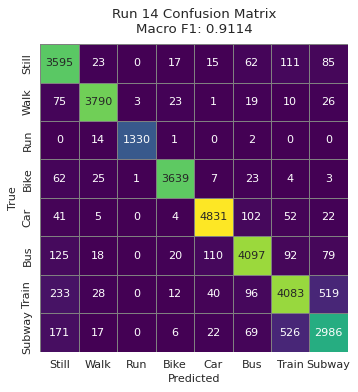


=== Run 15/30 — Params: {'subsample': 0.9, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 150, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0} ===
Macro-average F1 Score: 0.9007

Classification Report:
              precision    recall  f1-score   support

       Still     0.8139    0.9122    0.8603      3908
        Walk     0.9620    0.9564    0.9592      3947
         Run     0.9963    0.9866    0.9914      1347
        Bike     0.9720    0.9673    0.9696      3764
         Car     0.9478    0.9442    0.9460      5057
         Bus     0.8987    0.8831    0.8908      4541
       Train     0.8272    0.7958    0.8112      5011
      Subway     0.7908    0.7638    0.7771      3797

    accuracy                         0.8920     31372
   macro avg     0.9011    0.9012    0.9007     31372
weighted avg     0.8925    0.8920    0.8918     31372



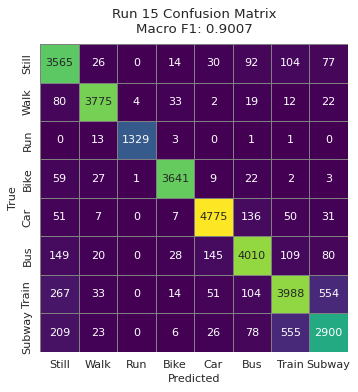


=== Run 16/30 — Params: {'subsample': 0.6, 'reg_lambda': 3, 'reg_alpha': 0.1, 'n_estimators': 150, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 0.1, 'colsample_bytree': 1.0} ===
Macro-average F1 Score: 0.9054

Classification Report:
              precision    recall  f1-score   support

       Still     0.8252    0.9110    0.8660      3908
        Walk     0.9665    0.9574    0.9619      3947
         Run     0.9963    0.9889    0.9925      1347
        Bike     0.9769    0.9652    0.9710      3764
         Car     0.9547    0.9498    0.9522      5057
         Bus     0.9099    0.8919    0.9008      4541
       Train     0.8236    0.8040    0.8137      5011
      Subway     0.7932    0.7767    0.7848      3797

    accuracy                         0.8968     31372
   macro avg     0.9058    0.9056    0.9054     31372
weighted avg     0.8975    0.8968    0.8969     31372



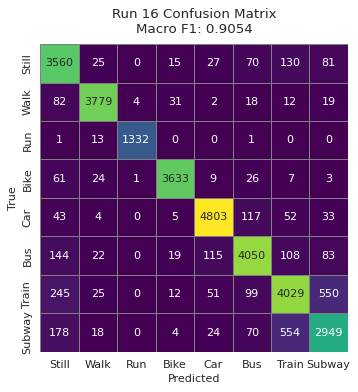


=== Run 17/30 — Params: {'subsample': 0.9, 'reg_lambda': 1, 'reg_alpha': 0.01, 'n_estimators': 250, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.5} ===
Macro-average F1 Score: 0.9110

Classification Report:
              precision    recall  f1-score   support

       Still     0.8298    0.9168    0.8711      3908
        Walk     0.9668    0.9582    0.9625      3947
         Run     0.9963    0.9874    0.9918      1347
        Bike     0.9783    0.9684    0.9733      3764
         Car     0.9636    0.9529    0.9582      5057
         Bus     0.9150    0.9029    0.9089      4541
       Train     0.8355    0.8160    0.8256      5011
      Subway     0.8065    0.7869    0.7966      3797

    accuracy                         0.9032     31372
   macro avg     0.9115    0.9112    0.9110     31372
weighted avg     0.9040    0.9032    0.9033     31372



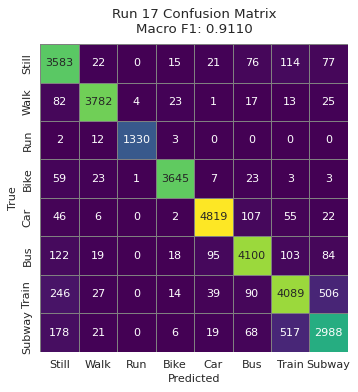


=== Run 18/30 — Params: {'subsample': 0.6, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 150, 'min_child_weight': 7, 'max_depth': 7, 'learning_rate': 0.3, 'gamma': 0.3, 'colsample_bytree': 0.5} ===
Macro-average F1 Score: 0.9027

Classification Report:
              precision    recall  f1-score   support

       Still     0.8275    0.9012    0.8628      3908
        Walk     0.9636    0.9600    0.9618      3947
         Run     0.9963    0.9896    0.9929      1347
        Bike     0.9729    0.9644    0.9686      3764
         Car     0.9519    0.9462    0.9490      5057
         Bus     0.9024    0.8917    0.8970      4541
       Train     0.8188    0.8010    0.8098      5011
      Subway     0.7899    0.7696    0.7796      3797

    accuracy                         0.8939     31372
   macro avg     0.9029    0.9030    0.9027     31372
weighted avg     0.8943    0.8939    0.8939     31372



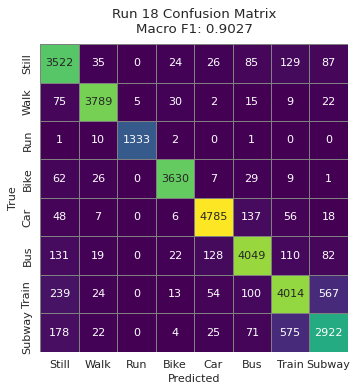


=== Run 19/30 — Params: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 0.01, 'n_estimators': 150, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.4, 'gamma': 0, 'colsample_bytree': 0.7} ===
Macro-average F1 Score: 0.9044

Classification Report:
              precision    recall  f1-score   support

       Still     0.8261    0.9071    0.8647      3908
        Walk     0.9662    0.9554    0.9608      3947
         Run     0.9970    0.9889    0.9929      1347
        Bike     0.9746    0.9681    0.9713      3764
         Car     0.9577    0.9480    0.9528      5057
         Bus     0.9089    0.8923    0.9005      4541
       Train     0.8230    0.8054    0.8141      5011
      Subway     0.7847    0.7719    0.7783      3797

    accuracy                         0.8959     31372
   macro avg     0.9048    0.9046    0.9044     31372
weighted avg     0.8966    0.8959    0.8959     31372



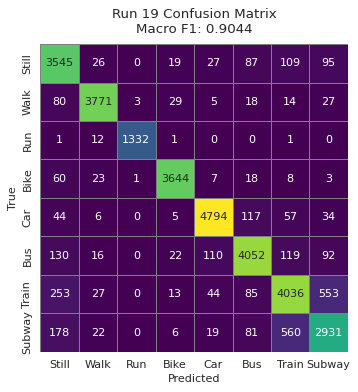


=== Run 20/30 — Params: {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0.01, 'n_estimators': 150, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 0.7} ===
Macro-average F1 Score: 0.9040

Classification Report:
              precision    recall  f1-score   support

       Still     0.8296    0.9084    0.8672      3908
        Walk     0.9656    0.9592    0.9624      3947
         Run     0.9963    0.9889    0.9925      1347
        Bike     0.9772    0.9663    0.9717      3764
         Car     0.9602    0.9500    0.9551      5057
         Bus     0.9093    0.8936    0.9014      4541
       Train     0.8172    0.8048    0.8110      5011
      Subway     0.7794    0.7619    0.7705      3797

    accuracy                         0.8955     31372
   macro avg     0.9043    0.9041    0.9040     31372
weighted avg     0.8961    0.8955    0.8955     31372



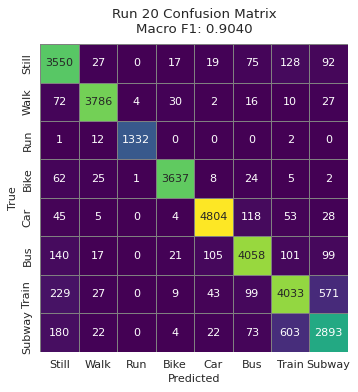


=== Run 21/30 — Params: {'subsample': 1.0, 'reg_lambda': 1.5, 'reg_alpha': 0.1, 'n_estimators': 150, 'min_child_weight': 7, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.5} ===
Macro-average F1 Score: 0.8857

Classification Report:
              precision    recall  f1-score   support

       Still     0.7989    0.8984    0.8457      3908
        Walk     0.9575    0.9579    0.9577      3947
         Run     0.9970    0.9889    0.9929      1347
        Bike     0.9651    0.9623    0.9637      3764
         Car     0.9320    0.9296    0.9308      5057
         Bus     0.8794    0.8659    0.8726      4541
       Train     0.7988    0.7719    0.7851      5011
      Subway     0.7591    0.7161    0.7370      3797

    accuracy                         0.8755     31372
   macro avg     0.8860    0.8864    0.8857     31372
weighted avg     0.8756    0.8755    0.8750     31372



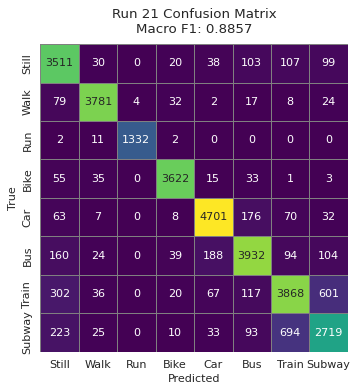


=== Run 22/30 — Params: {'subsample': 0.6, 'reg_lambda': 3, 'reg_alpha': 0.1, 'n_estimators': 250, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7} ===
Macro-average F1 Score: 0.9072

Classification Report:
              precision    recall  f1-score   support

       Still     0.8201    0.9214    0.8678      3908
        Walk     0.9671    0.9597    0.9634      3947
         Run     0.9978    0.9881    0.9929      1347
        Bike     0.9748    0.9671    0.9709      3764
         Car     0.9565    0.9519    0.9542      5057
         Bus     0.9111    0.8910    0.9009      4541
       Train     0.8311    0.8072    0.8190      5011
      Subway     0.8038    0.7738    0.7885      3797

    accuracy                         0.8990     31372
   macro avg     0.9078    0.9075    0.9072     31372
weighted avg     0.8997    0.8990    0.8989     31372



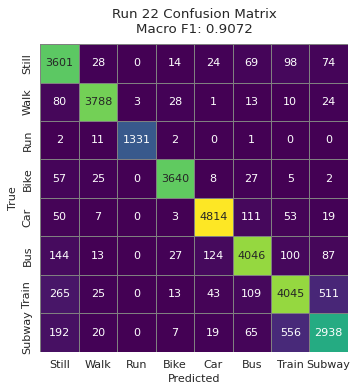


=== Run 23/30 — Params: {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0.01, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.4, 'gamma': 0.1, 'colsample_bytree': 1.0} ===
Macro-average F1 Score: 0.9114

Classification Report:
              precision    recall  f1-score   support

       Still     0.8333    0.9184    0.8738      3908
        Walk     0.9655    0.9577    0.9616      3947
         Run     0.9948    0.9889    0.9918      1347
        Bike     0.9734    0.9639    0.9686      3764
         Car     0.9629    0.9555    0.9592      5057
         Bus     0.9150    0.9029    0.9089      4541
       Train     0.8425    0.8146    0.8283      5011
      Subway     0.8053    0.7933    0.7993      3797

    accuracy                         0.9038     31372
   macro avg     0.9116    0.9119    0.9114     31372
weighted avg     0.9045    0.9038    0.9038     31372



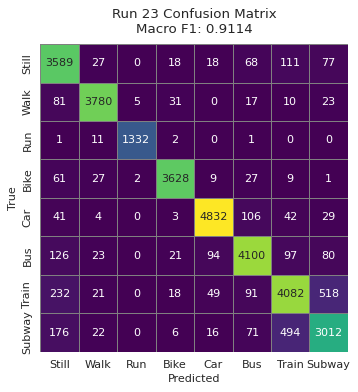


=== Run 24/30 — Params: {'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alpha': 0.1, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 0.7} ===
Macro-average F1 Score: 0.9095

Classification Report:
              precision    recall  f1-score   support

       Still     0.8300    0.9158    0.8708      3908
        Walk     0.9654    0.9605    0.9629      3947
         Run     0.9970    0.9881    0.9925      1347
        Bike     0.9777    0.9671    0.9724      3764
         Car     0.9572    0.9514    0.9543      5057
         Bus     0.9159    0.8969    0.9063      4541
       Train     0.8366    0.8124    0.8243      5011
      Subway     0.7990    0.7861    0.7925      3797

    accuracy                         0.9015     31372
   macro avg     0.9099    0.9098    0.9095     31372
weighted avg     0.9022    0.9015    0.9015     31372



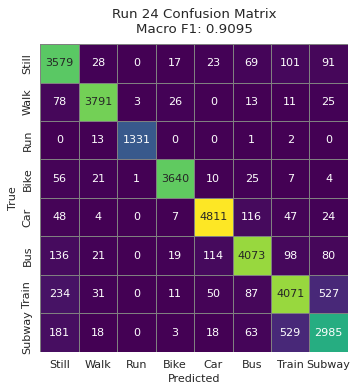


=== Run 25/30 — Params: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 1.0} ===
Macro-average F1 Score: 0.9054

Classification Report:
              precision    recall  f1-score   support

       Still     0.8237    0.9158    0.8673      3908
        Walk     0.9695    0.9574    0.9634      3947
         Run     0.9970    0.9881    0.9925      1347
        Bike     0.9717    0.9663    0.9690      3764
         Car     0.9529    0.9490    0.9510      5057
         Bus     0.9110    0.8901    0.9004      4541
       Train     0.8238    0.8050    0.8143      5011
      Subway     0.7976    0.7732    0.7852      3797

    accuracy                         0.8969     31372
   macro avg     0.9059    0.9056    0.9054     31372
weighted avg     0.8976    0.8969    0.8969     31372



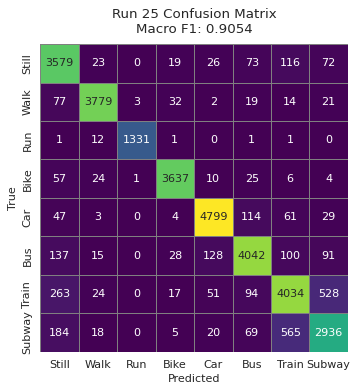


=== Run 26/30 — Params: {'subsample': 0.7, 'reg_lambda': 2, 'reg_alpha': 0.01, 'n_estimators': 150, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.5} ===
Macro-average F1 Score: 0.9055

Classification Report:
              precision    recall  f1-score   support

       Still     0.8258    0.9125    0.8670      3908
        Walk     0.9653    0.9582    0.9617      3947
         Run     0.9963    0.9881    0.9922      1347
        Bike     0.9717    0.9668    0.9692      3764
         Car     0.9561    0.9508    0.9534      5057
         Bus     0.9122    0.8943    0.9031      4541
       Train     0.8251    0.8032    0.8140      5011
      Subway     0.7938    0.7727    0.7831      3797

    accuracy                         0.8972     31372
   macro avg     0.9058    0.9058    0.9055     31372
weighted avg     0.8977    0.8972    0.8971     31372



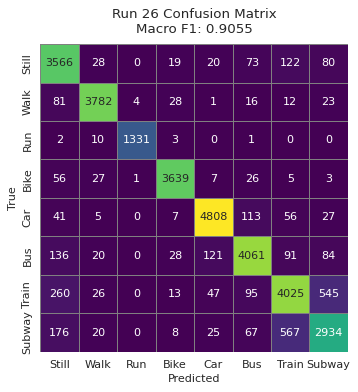


=== Run 27/30 — Params: {'subsample': 0.6, 'reg_lambda': 3, 'reg_alpha': 1, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.4, 'gamma': 0.3, 'colsample_bytree': 0.7} ===
Macro-average F1 Score: 0.9076

Classification Report:
              precision    recall  f1-score   support

       Still     0.8353    0.9122    0.8721      3908
        Walk     0.9609    0.9592    0.9601      3947
         Run     0.9963    0.9881    0.9922      1347
        Bike     0.9727    0.9657    0.9692      3764
         Car     0.9555    0.9502    0.9528      5057
         Bus     0.9062    0.8961    0.9011      4541
       Train     0.8348    0.8126    0.8235      5011
      Subway     0.8010    0.7793    0.7900      3797

    accuracy                         0.8996     31372
   macro avg     0.9078    0.9079    0.9076     31372
weighted avg     0.8999    0.8996    0.8995     31372



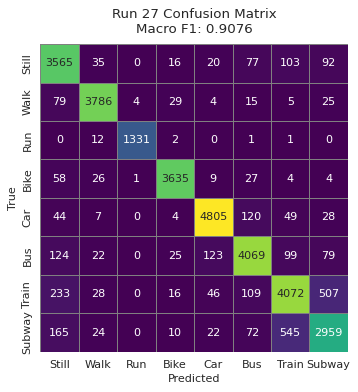


=== Run 28/30 — Params: {'subsample': 0.7, 'reg_lambda': 3, 'reg_alpha': 0, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 0.3, 'colsample_bytree': 1.0} ===
Macro-average F1 Score: 0.9095

Classification Report:
              precision    recall  f1-score   support

       Still     0.8305    0.9138    0.8701      3908
        Walk     0.9656    0.9587    0.9621      3947
         Run     0.9978    0.9881    0.9929      1347
        Bike     0.9711    0.9649    0.9680      3764
         Car     0.9575    0.9525    0.9550      5057
         Bus     0.9123    0.8980    0.9051      4541
       Train     0.8381    0.8182    0.8280      5011
      Subway     0.8068    0.7832    0.7949      3797

    accuracy                         0.9017     31372
   macro avg     0.9099    0.9097    0.9095     31372
weighted avg     0.9022    0.9017    0.9016     31372



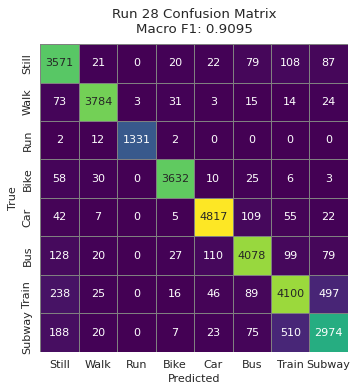


=== Run 29/30 — Params: {'subsample': 1.0, 'reg_lambda': 3, 'reg_alpha': 0.1, 'n_estimators': 250, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1.0} ===
Macro-average F1 Score: 0.9003

Classification Report:
              precision    recall  f1-score   support

       Still     0.8144    0.9117    0.8603      3908
        Walk     0.9618    0.9574    0.9596      3947
         Run     0.9977    0.9874    0.9925      1347
        Bike     0.9709    0.9671    0.9690      3764
         Car     0.9447    0.9460    0.9454      5057
         Bus     0.9000    0.8835    0.8917      4541
       Train     0.8270    0.7984    0.8125      5011
      Subway     0.7896    0.7540    0.7714      3797

    accuracy                         0.8916     31372
   macro avg     0.9008    0.9007    0.9003     31372
weighted avg     0.8920    0.8916    0.8914     31372



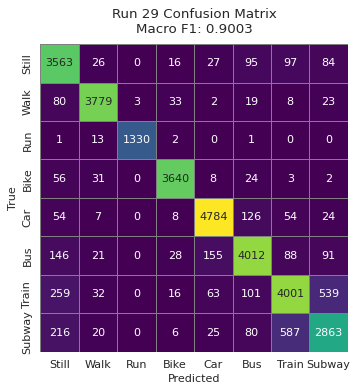


=== Run 30/30 — Params: {'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alpha': 0.01, 'n_estimators': 200, 'min_child_weight': 7, 'max_depth': 9, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.7} ===
Macro-average F1 Score: 0.9075

Classification Report:
              precision    recall  f1-score   support

       Still     0.8283    0.9135    0.8688      3908
        Walk     0.9655    0.9579    0.9617      3947
         Run     0.9963    0.9896    0.9929      1347
        Bike     0.9771    0.9644    0.9707      3764
         Car     0.9617    0.9492    0.9554      5057
         Bus     0.9092    0.8978    0.9035      4541
       Train     0.8309    0.8068    0.8187      5011
      Subway     0.7932    0.7838    0.7884      3797

    accuracy                         0.8992     31372
   macro avg     0.9078    0.9079    0.9075     31372
weighted avg     0.9000    0.8992    0.8993     31372



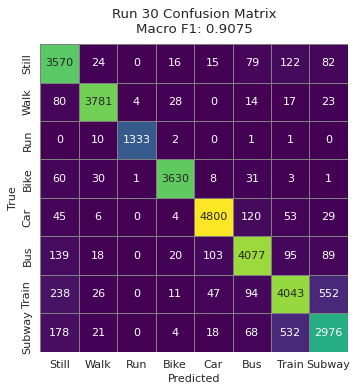


Best hyperparameters (by macro F1):
{'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0.01, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.4, 'gamma': 0.1, 'colsample_bytree': 1.0}
Best test-set macro F1: 0.9114


In [12]:
import gc
from numba import cuda
from tqdm.auto import tqdm
import xgboost as xgb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# === 0. How many random configs to try? ===
n_iter_search = 30   # ← set this to however many runs you want
'''
# === 1. Sample your data (20% for speed) ===
df_sample = df_wide.sample(frac=0.2, random_state=42).reset_index(drop=True)
print("Sampled shape (20%):", df_sample.shape)
print("Mode distribution in sample:\n", df_sample['mode'].value_counts())

# === 2. Prepare features & labels ===
X = df_sample.drop(columns=['window_id','mode'])
y = df_sample['mode']

# === 3. Train/Test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("Train size:", X_train.shape, "| Test size:", X_test.shape)

# === 4. Encode y for XGBoost (0–7) ===
y_train_enc = y_train.astype(int) - 1
y_test_enc  = y_test.astype(int)  - 1
'''
# plotting defaults
sns.set_style("white")
cmap_choice = plt.cm.viridis
labels = ["Still","Walk","Run","Bike","Car","Bus","Train","Subway"]

# === 5. Define hyperparameter search space ===
param_dist = {
    "n_estimators":     [150, 200, 250],           # number of boosting rounds 
    "max_depth":        [7, 9, 10],                  # tree complexity
    "learning_rate":    [0.1, 0.2, 0.3, 0.4],       # shrinkage factor
    "subsample":        [0.6, 0.7, 0.8, 0.9, 1.0],          # row sampling
    "colsample_bytree": [0.5, 0.7, 0.8, 1.0],               # feature sampling
    "gamma":            [0, 0.1, 0.2, 0.3, 0.5],            # min loss reduction
    "min_child_weight": [1, 3, 5, 7],                      # minimum leaf instance
    "reg_alpha":        [0, 0.01, 0.1, 1],                  # L1 regularization
    "reg_lambda":       [1, 1.5, 2, 3]                      # L2 regularization
}

# === 6. Sample random hyperparameter sets ===
param_list = list(ParameterSampler(param_dist, n_iter_search, random_state=42))

# Prepare to track the best
best_f1    = -1.0
best_model = None
best_params= None

for idx, params in enumerate(param_list, start=1):
    print(f"\n=== Run {idx}/{n_iter_search} — Params: {params} ===")
    model = xgb.XGBClassifier(
        tree_method='hist',
        predictor='gpu_predictor',
        device='cuda:0',
        random_state=42,
        verbosity=0,
        n_jobs=-1,
        **params
    )
    model.fit(X_train, y_train_enc)
    y_pred = model.predict(X_test)
    
    # compute macro (un-weighted) F1
    f1 = f1_score(y_test_enc, y_pred, average='macro')
    print(f"Macro-average F1 Score: {f1:.4f}")
    
    # classification report
    print("\nClassification Report:")
    print(classification_report(y_test_enc, y_pred, target_names=labels, digits=4))
    
    # plot confusion matrix only
    cm = confusion_matrix(y_test_enc, y_pred)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(6,5), dpi=80)
    sns.heatmap(cm_df, annot=True, fmt='d',
                cmap=cmap_choice, linewidths=0.5,
                linecolor='gray', square=True, cbar=False)
    plt.title(f"Run {idx} Confusion Matrix\nMacro F1: {f1:.4f}", pad=10)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    # update best model by macro F1
    if f1 > best_f1:
        best_f1, best_params = f1, params

# After loop
print("\n" + "="*60)
print("Best hyperparameters (by macro F1):")
print(best_params)
print(f"Best test-set macro F1: {best_f1:.4f}")
print("="*60)


In [ ]:
#Here are more samples 40% with best from above

Sampled shape (40%): (313715, 3850)
Mode distribution in sample:
 mode
5.0    50750
7.0    49890
6.0    45449
2.0    39362
1.0    39226
8.0    38046
4.0    37644
3.0    13348
Name: count, dtype: int64
Train size: (250972, 3848) | Test size: (62743, 3848)

=== Run 1/5 — Params: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 250, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.4, 'gamma': 0.1, 'colsample_bytree': 0.8} ===
Macro-average F1 Score: 0.9243

Classification Report:
              precision    recall  f1-score   support

       Still     0.8507    0.9262    0.8869      7845
        Walk     0.9715    0.9560    0.9637      7872
         Run     0.9989    0.9899    0.9944      2670
        Bike     0.9828    0.9705    0.9766      7529
         Car     0.9661    0.9676    0.9668     10150
         Bus     0.9286    0.9182    0.9233      9090
       Train     0.8621    0.8489    0.8554      9978
      Subway     0.8391    0.8155    0.8271      7609



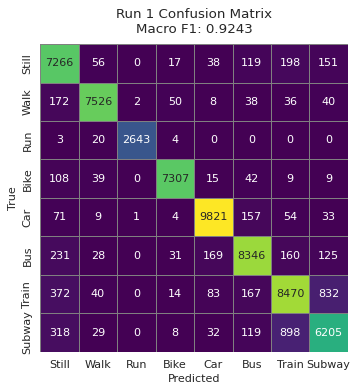


=== Run 2/5 — Params: {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0.01, 'n_estimators': 250, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 1.0} ===
Macro-average F1 Score: 0.9221

Classification Report:
              precision    recall  f1-score   support

       Still     0.8487    0.9284    0.8868      7845
        Walk     0.9717    0.9567    0.9642      7872
         Run     0.9981    0.9891    0.9936      2670
        Bike     0.9833    0.9691    0.9761      7529
         Car     0.9635    0.9649    0.9642     10150
         Bus     0.9234    0.9169    0.9202      9090
       Train     0.8587    0.8412    0.8498      9978
      Subway     0.8348    0.8098    0.8221      7609

    accuracy                         0.9154     62743
   macro avg     0.9228    0.9220    0.9221     62743
weighted avg     0.9160    0.9154    0.9154     62743



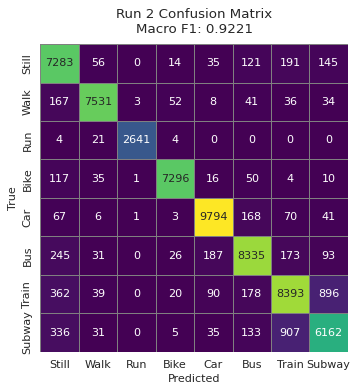


=== Run 3/5 — Params: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 250, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.4, 'gamma': 0.2, 'colsample_bytree': 0.8} ===
Macro-average F1 Score: 0.9242

Classification Report:
              precision    recall  f1-score   support

       Still     0.8528    0.9276    0.8886      7845
        Walk     0.9692    0.9581    0.9636      7872
         Run     0.9989    0.9888    0.9938      2670
        Bike     0.9820    0.9696    0.9757      7529
         Car     0.9651    0.9688    0.9669     10150
         Bus     0.9283    0.9165    0.9224      9090
       Train     0.8634    0.8506    0.8569      9978
      Subway     0.8396    0.8119    0.8255      7609

    accuracy                         0.9178     62743
   macro avg     0.9249    0.9240    0.9242     62743
weighted avg     0.9183    0.9178    0.9178     62743



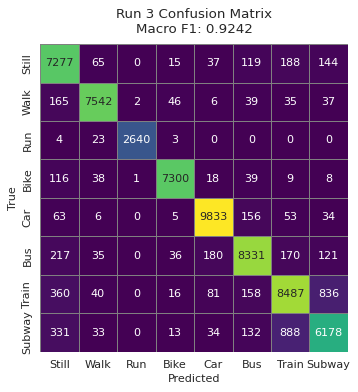


=== Run 4/5 — Params: {'subsample': 0.9, 'reg_lambda': 1.5, 'reg_alpha': 0.1, 'n_estimators': 250, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.4, 'gamma': 0.1, 'colsample_bytree': 0.8} ===
Macro-average F1 Score: 0.9252

Classification Report:
              precision    recall  f1-score   support

       Still     0.8516    0.9275    0.8879      7845
        Walk     0.9705    0.9562    0.9633      7872
         Run     0.9985    0.9884    0.9934      2670
        Bike     0.9829    0.9709    0.9769      7529
         Car     0.9669    0.9677    0.9673     10150
         Bus     0.9279    0.9202    0.9241      9090
       Train     0.8647    0.8550    0.8598      9978
      Subway     0.8453    0.8136    0.8292      7609

    accuracy                         0.9190     62743
   macro avg     0.9260    0.9249    0.9252     62743
weighted avg     0.9195    0.9190    0.9190     62743



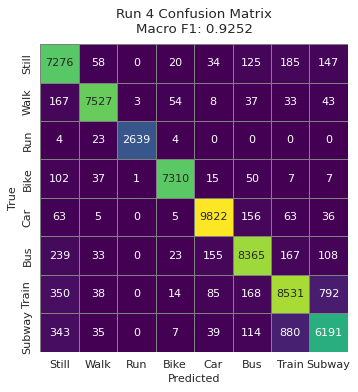


=== Run 5/5 — Params: {'subsample': 1.0, 'reg_lambda': 1.5, 'reg_alpha': 0.1, 'n_estimators': 250, 'min_child_weight': 7, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 0.1, 'colsample_bytree': 0.8} ===
Macro-average F1 Score: 0.9247

Classification Report:
              precision    recall  f1-score   support

       Still     0.8544    0.9308    0.8910      7845
        Walk     0.9729    0.9559    0.9643      7872
         Run     0.9985    0.9891    0.9938      2670
        Bike     0.9841    0.9710    0.9775      7529
         Car     0.9660    0.9667    0.9664     10150
         Bus     0.9246    0.9165    0.9206      9090
       Train     0.8630    0.8506    0.8568      9978
      Subway     0.8399    0.8154    0.8274      7609

    accuracy                         0.9182     62743
   macro avg     0.9254    0.9245    0.9247     62743
weighted avg     0.9188    0.9182    0.9183     62743



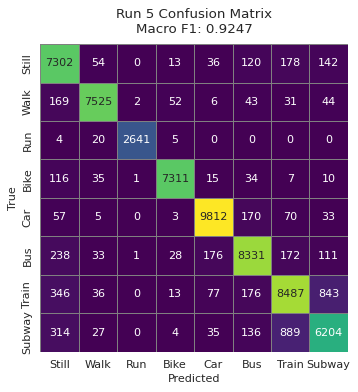


Best hyperparameters (by macro F1):
{'subsample': 0.9, 'reg_lambda': 1.5, 'reg_alpha': 0.1, 'n_estimators': 250, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.4, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best test-set macro F1: 0.9252


In [13]:
import gc
from numba import cuda
from tqdm.auto import tqdm
import xgboost as xgb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# === 0. How many random configs to try? ===
n_iter_search = 5   # ← set this to however many runs you want

# === 1. Sample your data (40% for speed) ===
df_sample = df_wide.sample(frac=0.4, random_state=42).reset_index(drop=True)
print("Sampled shape (40%):", df_sample.shape)
print("Mode distribution in sample:\n", df_sample['mode'].value_counts())

# === 2. Prepare features & labels ===
X = df_sample.drop(columns=['window_id','mode'])
y = df_sample['mode']

# === 3. Train/Test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("Train size:", X_train.shape, "| Test size:", X_test.shape)

# === 4. Encode y for XGBoost (0–7) ===
y_train_enc = y_train.astype(int) - 1
y_test_enc  = y_test.astype(int)  - 1

# plotting defaults
sns.set_style("white")
cmap_choice = plt.cm.viridis
labels = ["Still","Walk","Run","Bike","Car","Bus","Train","Subway"]

# === 5. Define hyperparameter search space ===
param_dist = {
    "n_estimators":     [250],           # number of boosting rounds 
    "max_depth":        [9, 10],                  # tree complexity
    "learning_rate":    [0.2, 0.3, 0.4],       # shrinkage factor
    "subsample":        [0.8, 0.9, 1.0],          # row sampling
    "colsample_bytree": [0.8, 1.0],               # feature sampling
    "gamma":            [0.1, 0.2],            # min loss reduction
    "min_child_weight": [5, 7],                      # minimum leaf instance
    "reg_alpha":        [0.01, 0.1],                  # L1 regularization
    "reg_lambda":       [1, 1.5]                      # L2 regularization
}

# === 6. Sample random hyperparameter sets ===
param_list = list(ParameterSampler(param_dist, n_iter_search, random_state=42))

# Prepare to track the best
best_f1    = -1.0
best_model = None
best_params= None

for idx, params in enumerate(param_list, start=1):
    print(f"\n=== Run {idx}/{n_iter_search} — Params: {params} ===")
    model = xgb.XGBClassifier(
        tree_method='hist',
        predictor='gpu_predictor',
        device='cuda:0',
        random_state=42,
        verbosity=0,
        n_jobs=-1,
        **params
    )
    model.fit(X_train, y_train_enc)
    y_pred = model.predict(X_test)
    
    # compute macro (un-weighted) F1
    f1 = f1_score(y_test_enc, y_pred, average='macro')
    print(f"Macro-average F1 Score: {f1:.4f}")
    
    # classification report
    print("\nClassification Report:")
    print(classification_report(y_test_enc, y_pred, target_names=labels, digits=4))
    
    # plot confusion matrix only
    cm = confusion_matrix(y_test_enc, y_pred)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(6,5), dpi=80)
    sns.heatmap(cm_df, annot=True, fmt='d',
                cmap=cmap_choice, linewidths=0.5,
                linecolor='gray', square=True, cbar=False)
    plt.title(f"Run {idx} Confusion Matrix\nMacro F1: {f1:.4f}", pad=10)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    # update best model by macro F1
    if f1 > best_f1:
        best_f1, best_params = f1, params

# After loop
print("\n" + "="*60)
print("Best hyperparameters (by macro F1):")
print(best_params)
print(f"Best test-set macro F1: {best_f1:.4f}")
print("="*60)


Sampled shape (80%): (627430, 3850)
Mode distribution in sample:
 mode
5.0    101594
7.0    100147
6.0     90659
2.0     78589
1.0     78279
8.0     76014
4.0     75190
3.0     26958
Name: count, dtype: int64
Train size: (501944, 3848) | Test size: (125486, 3848)

=== Run 1/5 — Params: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 250, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.4, 'gamma': 0.1, 'colsample_bytree': 0.8} ===
Macro-average F1 Score: 0.9358

Classification Report:
              precision    recall  f1-score   support

       Still     0.8716    0.9377    0.9035     15656
        Walk     0.9753    0.9623    0.9687     15718
         Run     0.9987    0.9915    0.9951      5391
        Bike     0.9857    0.9732    0.9794     15038
         Car     0.9749    0.9706    0.9727     20319
         Bus     0.9437    0.9344    0.9390     18132
       Train     0.8782    0.8706    0.8744     20029
      Subway     0.8626    0.8452    0.8538   

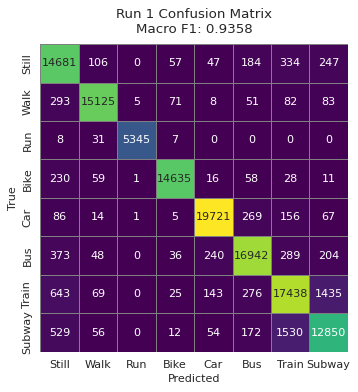


=== Run 2/5 — Params: {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0.01, 'n_estimators': 250, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 1.0} ===
Macro-average F1 Score: 0.9331

Classification Report:
              precision    recall  f1-score   support

       Still     0.8634    0.9379    0.8991     15656
        Walk     0.9739    0.9620    0.9679     15718
         Run     0.9993    0.9911    0.9952      5391
        Bike     0.9856    0.9714    0.9785     15038
         Car     0.9739    0.9716    0.9727     20319
         Bus     0.9391    0.9298    0.9344     18132
       Train     0.8748    0.8664    0.8706     20029
      Subway     0.8602    0.8331    0.8464     15203

    accuracy                         0.9274    125486
   macro avg     0.9338    0.9329    0.9331    125486
weighted avg     0.9280    0.9274    0.9274    125486



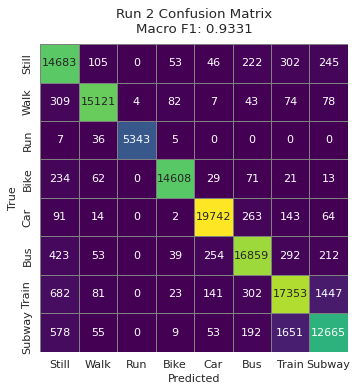


=== Run 3/5 — Params: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 250, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.4, 'gamma': 0.2, 'colsample_bytree': 0.8} ===
Macro-average F1 Score: 0.9358

Classification Report:
              precision    recall  f1-score   support

       Still     0.8728    0.9374    0.9039     15656
        Walk     0.9727    0.9639    0.9683     15718
         Run     0.9987    0.9907    0.9947      5391
        Bike     0.9841    0.9725    0.9783     15038
         Car     0.9737    0.9738    0.9737     20319
         Bus     0.9430    0.9327    0.9378     18132
       Train     0.8794    0.8710    0.8752     20029
      Subway     0.8667    0.8435    0.8549     15203

    accuracy                         0.9304    125486
   macro avg     0.9364    0.9357    0.9358    125486
weighted avg     0.9309    0.9304    0.9305    125486



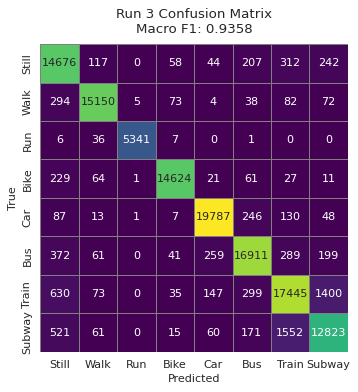


=== Run 4/5 — Params: {'subsample': 0.9, 'reg_lambda': 1.5, 'reg_alpha': 0.1, 'n_estimators': 250, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.4, 'gamma': 0.1, 'colsample_bytree': 0.8} ===
Macro-average F1 Score: 0.9361

Classification Report:
              precision    recall  f1-score   support

       Still     0.8727    0.9377    0.9040     15656
        Walk     0.9755    0.9635    0.9694     15718
         Run     0.9989    0.9913    0.9951      5391
        Bike     0.9864    0.9721    0.9792     15038
         Car     0.9752    0.9729    0.9741     20319
         Bus     0.9434    0.9334    0.9384     18132
       Train     0.8776    0.8726    0.8751     20029
      Subway     0.8640    0.8435    0.8536     15203

    accuracy                         0.9306    125486
   macro avg     0.9367    0.9359    0.9361    125486
weighted avg     0.9312    0.9306    0.9307    125486



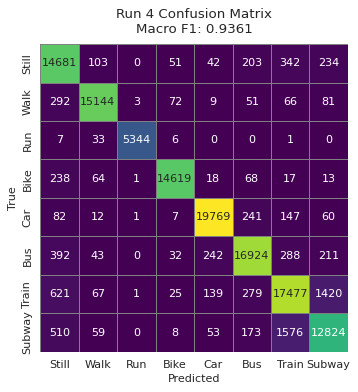


=== Run 5/5 — Params: {'subsample': 1.0, 'reg_lambda': 1.5, 'reg_alpha': 0.1, 'n_estimators': 250, 'min_child_weight': 7, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 0.1, 'colsample_bytree': 0.8} ===
Macro-average F1 Score: 0.9359

Classification Report:
              precision    recall  f1-score   support

       Still     0.8684    0.9404    0.9030     15656
        Walk     0.9763    0.9633    0.9697     15718
         Run     0.9985    0.9917    0.9951      5391
        Bike     0.9860    0.9727    0.9793     15038
         Car     0.9749    0.9737    0.9743     20319
         Bus     0.9426    0.9313    0.9369     18132
       Train     0.8778    0.8724    0.8751     20029
      Subway     0.8678    0.8402    0.8538     15203

    accuracy                         0.9304    125486
   macro avg     0.9365    0.9357    0.9359    125486
weighted avg     0.9310    0.9304    0.9305    125486



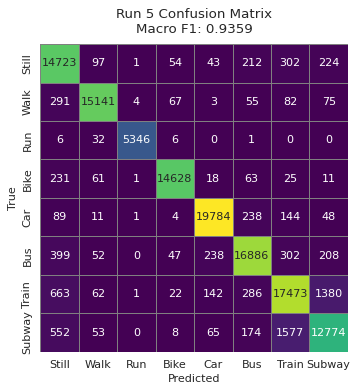


Best hyperparameters (by macro F1):
{'subsample': 0.9, 'reg_lambda': 1.5, 'reg_alpha': 0.1, 'n_estimators': 250, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.4, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best test-set macro F1: 0.9361


In [14]:
import gc
from numba import cuda
from tqdm.auto import tqdm
import xgboost as xgb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# === 0. How many random configs to try? ===
n_iter_search = 5   # ← set this to however many runs you want

# === 1. Sample your data (80% for speed) ===
df_sample = df_wide.sample(frac=0.8, random_state=42).reset_index(drop=True)
print("Sampled shape (80%):", df_sample.shape)
print("Mode distribution in sample:\n", df_sample['mode'].value_counts())

# === 2. Prepare features & labels ===
X = df_sample.drop(columns=['window_id','mode'])
y = df_sample['mode']

# === 3. Train/Test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("Train size:", X_train.shape, "| Test size:", X_test.shape)

# === 4. Encode y for XGBoost (0–7) ===
y_train_enc = y_train.astype(int) - 1
y_test_enc  = y_test.astype(int)  - 1

# plotting defaults
sns.set_style("white")
cmap_choice = plt.cm.viridis
labels = ["Still","Walk","Run","Bike","Car","Bus","Train","Subway"]

# === 5. Define hyperparameter search space ===
param_dist = {
    "n_estimators":     [250],           # number of boosting rounds 
    "max_depth":        [9, 10],                  # tree complexity
    "learning_rate":    [0.2, 0.3, 0.4],       # shrinkage factor
    "subsample":        [0.8, 0.9, 1.0],          # row sampling
    "colsample_bytree": [0.8, 1.0],               # feature sampling
    "gamma":            [0.1, 0.2],            # min loss reduction
    "min_child_weight": [5, 7],                      # minimum leaf instance
    "reg_alpha":        [0.01, 0.1],                  # L1 regularization
    "reg_lambda":       [1, 1.5]                      # L2 regularization
}

# === 6. Sample random hyperparameter sets ===
param_list = list(ParameterSampler(param_dist, n_iter_search, random_state=42))

# Prepare to track the best
best_f1    = -1.0
best_model = None
best_params= None

for idx, params in enumerate(param_list, start=1):
    print(f"\n=== Run {idx}/{n_iter_search} — Params: {params} ===")
    model = xgb.XGBClassifier(
        tree_method='hist',
        predictor='gpu_predictor',
        device='cuda:0',
        random_state=42,
        verbosity=0,
        n_jobs=-1,
        **params
    )
    model.fit(X_train, y_train_enc)
    y_pred = model.predict(X_test)
    
    # compute macro (un-weighted) F1
    f1 = f1_score(y_test_enc, y_pred, average='macro')
    print(f"Macro-average F1 Score: {f1:.4f}")
    
    # classification report
    print("\nClassification Report:")
    print(classification_report(y_test_enc, y_pred, target_names=labels, digits=4))
    
    # plot confusion matrix only
    cm = confusion_matrix(y_test_enc, y_pred)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(6,5), dpi=80)
    sns.heatmap(cm_df, annot=True, fmt='d',
                cmap=cmap_choice, linewidths=0.5,
                linecolor='gray', square=True, cbar=False)
    plt.title(f"Run {idx} Confusion Matrix\nMacro F1: {f1:.4f}", pad=10)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    # update best model by macro F1
    if f1 > best_f1:
        best_f1, best_params = f1, params

# After loop
print("\n" + "="*60)
print("Best hyperparameters (by macro F1):")
print(best_params)
print(f"Best test-set macro F1: {best_f1:.4f}")
print("="*60)


In [11]:
gc.collect()
del model, y_pred

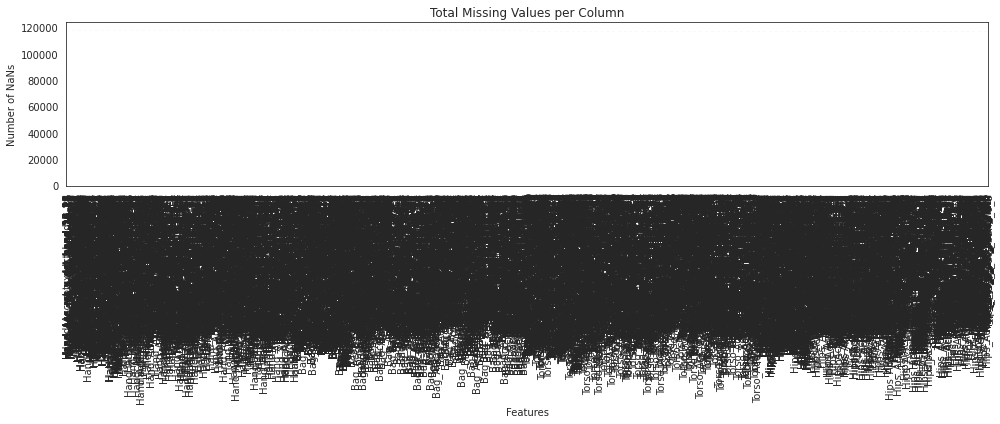

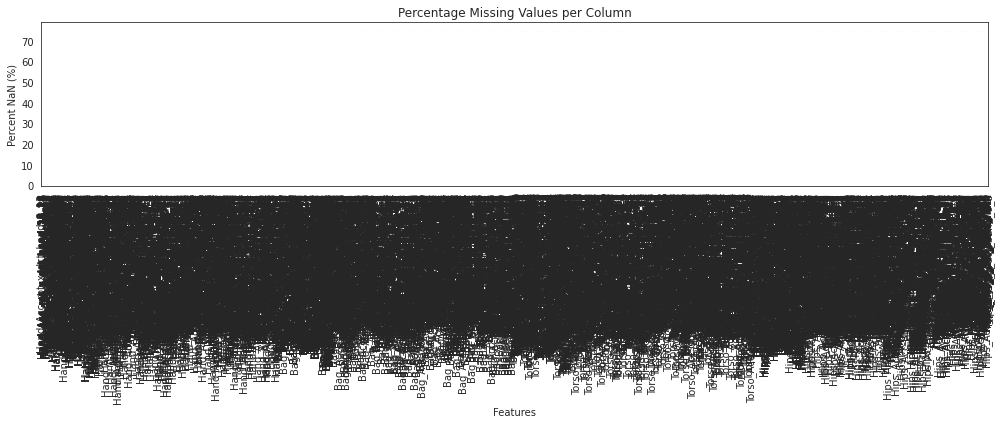

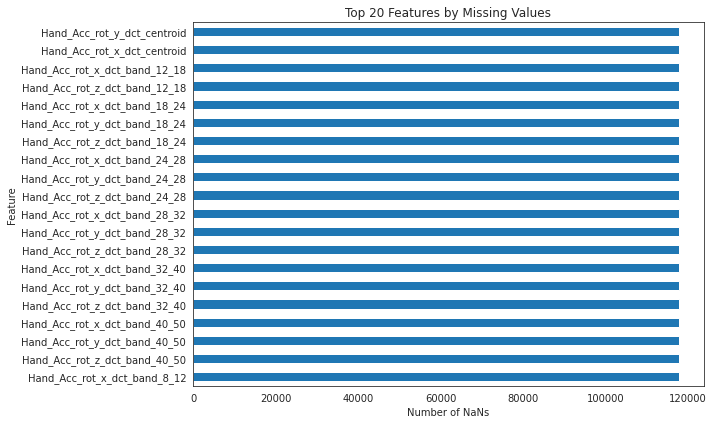

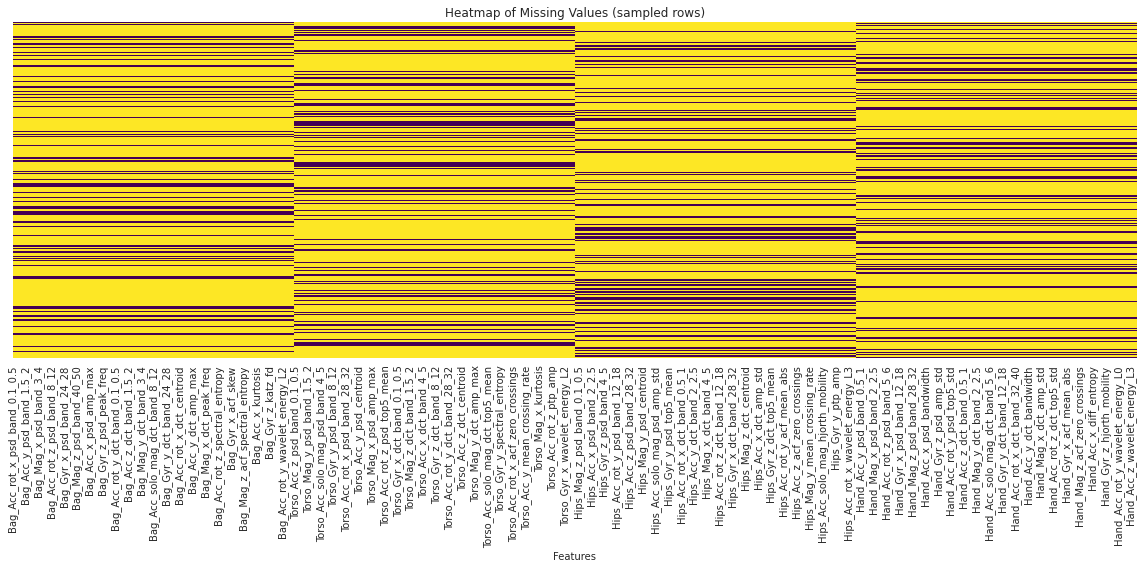

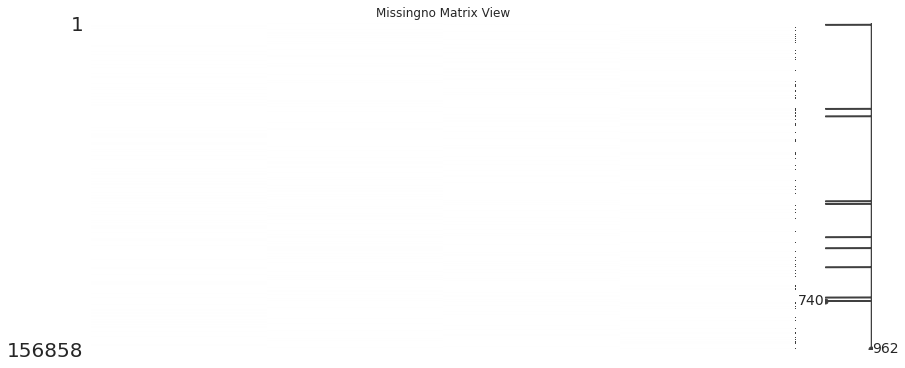

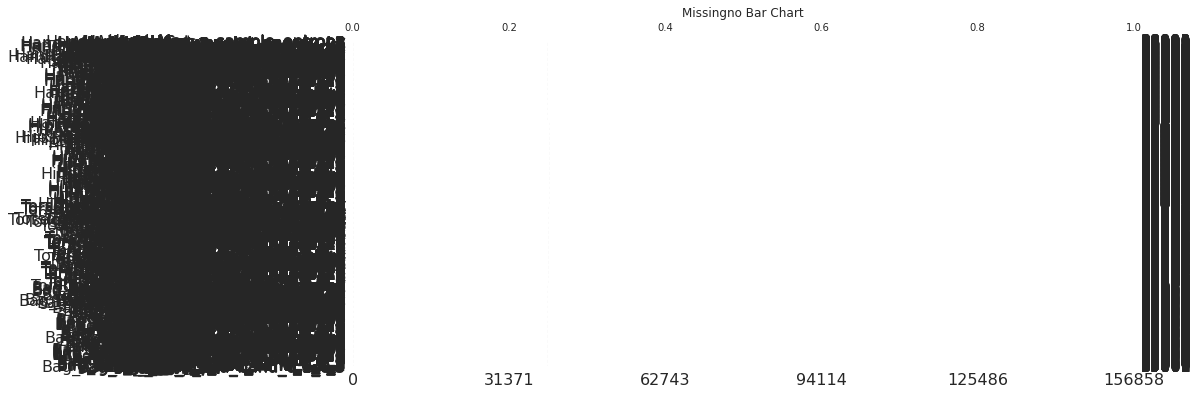

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# -- assume X is your DataFrame
# X = pd.read_csv("your_data.csv")

# 1. BAR CHARTS OF MISSING COUNTS & PERCENTAGES -----------------------------

# Count and percentage of missing values per column
missing_count = X.isna().sum()
missing_pct   = 100 * missing_count / len(X)
missing_df    = pd.DataFrame({
    'n_missing': missing_count,
    'pct_missing': missing_pct
}).sort_values('n_missing', ascending=False)

# Plot total missing per column
plt.figure(figsize=(14, 6))
missing_df['n_missing'].plot.bar()
plt.title("Total Missing Values per Column")
plt.ylabel("Number of NaNs")
plt.xlabel("Features")
plt.tight_layout()
plt.show()

# Plot percentage missing per column
plt.figure(figsize=(14, 6))
missing_df['pct_missing'].plot.bar(color='orange')
plt.title("Percentage Missing Values per Column")
plt.ylabel("Percent NaN (%)")
plt.xlabel("Features")
plt.tight_layout()
plt.show()


# 2. TOP-N HORIZONTAL BAR CHART ----------------------------------------------

# Show only top 20 features by missing count
top_n = 20
plt.figure(figsize=(10, 6))
missing_df['n_missing'].head(top_n).sort_values().plot.barh()
plt.title(f"Top {top_n} Features by Missing Values")
plt.xlabel("Number of NaNs")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# 3. SEABORN HEATMAP OF MISSING MASK (SAMPLED ROWS) --------------------------

# Sample rows for clarity
sample_frac = 5000 / len(X)
sample_df   = X.sample(frac=sample_frac if sample_frac < 1 else 1.0,
                       random_state=42)

plt.figure(figsize=(16, 8))
sns.heatmap(sample_df.isna(),
            cbar=False,
            yticklabels=False,
            cmap="viridis")
plt.title("Heatmap of Missing Values (sampled rows)")
plt.xlabel("Features")
plt.tight_layout()
plt.show()


# 4. MISSINGNO DIAGNOSTICS --------------------------------------------------

# 4.1. Matrix: nullity sparkline + summary bars
msno.matrix(X, figsize=(14, 6), sparkline=True)
plt.title("Missingno Matrix View")
plt.show()

# 4.2. Bar: count of non-missing values
msno.bar(X, figsize=(14, 6))
plt.title("Missingno Bar Chart")
plt.show()

# 4.3. Heatmap: correlation of missingness
msno.heatmap(X, figsize=(10, 8))
plt.title("Missingno Heatmap (Nullity Correlation)")
plt.show()

# 4.4. Dendrogram: hierarchical clustering of features by missingness
msno.dendrogram(X, figsize=(12, 8))
plt.title("Missingno Dendrogram (Cluster Missing Patterns)")
plt.show()


# 5. PAIRWISE MISSINGNESS CORRELATION HEATMAP -------------------------------

# Compute pairwise correlation of isna() booleans
isna_corr = X.isna().corr()

plt.figure(figsize=(12, 10))
sns.clustermap(isna_corr,
               cmap="mako",
               figsize=(12, 12),
               cbar_kws={'label': 'Missingness Corr.'})
plt.suptitle("Clustered Heatmap of Missingness Correlation", y=1.02)
plt.show()


# 6. CUSTOM CLUSTERMAP ON SUBSET ------------------------------------------------

# You may want to focus on the top-K most missing features
top_feats = missing_df['n_missing'].head(50).index
subset    = X[top_feats].isna()

sns.clustermap(subset,
               figsize=(12, 12),
               metric="jaccard",
               method="average",
               cbar_pos=(0.02, 0.8, 0.05, 0.18))
plt.suptitle("Clustermap of Top 50 Features by Missing Patterns", y=1.02)
plt.show()


In [ ]:
print("d")